In [ ]:
"""
Attention LSTM 모델 통합 버전 - 시계열 커피 가격 예측
이 스크립트는 Google Colab에서 실행할 수 있도록 모든 기능을 통합한 버전입니다.
다양한 손실 함수, 스케일링 옵션, 그리고 향상된 예측 기능을 제공합니다.

주요 기능:
1. 여러 손실 함수 지원 (MSE, Huber, Directional, Combined)
2. 가격 스케일링 옵션 (활성화/비활성화)
3. Entmax 기반 어텐션 메커니즘
4. 다양한 시각화 및 평가 도구

원본 구조:
- data_preprocessing.py - 데이터 전처리
- dataset.py - 데이터셋 클래스
- model.py - 모델 아키텍처
- training.py - 학습 및 예측
- utils.py - 유틸리티 기능
- main.py - 실행 로직
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import argparse
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# entmax 설치 확인
try:
    from entmax import Entmax15
except ImportError:
    print("⚠️ entmax 패키지를 찾을 수 없습니다. 설치를 시도합니다...")
    try:
        import sys
        !pip install entmax
        from entmax import Entmax15
        print("✅ entmax 패키지 설치 완료")
    except:
        print("❌ entmax 설치 실패. 대체 구현을 사용합니다.")
        # Entmax15의 대체 구현으로 softmax를 사용
        class Entmax15(nn.Module):
            def __init__(self, dim=None):
                super().__init__()
                self.dim = dim

            def forward(self, x):
                return nn.functional.softmax(x, dim=self.dim)

In [ ]:
# Google Drive 마운트 함수 (필요시 호출)
def mount_drive():
    """Google Drive를 마운트합니다 (Colab에서 실행 시)"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive 마운트 완료")
        return True
    except:
        print("Google Drive 마운트 실패 또는 필요 없음")
        return False

In [ ]:
#--------------------------- 1. 데이터 전처리 모듈 ---------------------------#

def add_volatility_features(df):
    """
    주가 변동성 관련 피처를 추가합니다.

    Args:
        df (pd.DataFrame): 입력 데이터프레임

    Returns:
        pd.DataFrame: 변동성 피처가 추가된 데이터프레임
    """
    # 절대 수익률
    df['abs_return'] = df['Coffee_Price_Return'].abs()

    # 5일, 10일 변동성 (rolling std)
    df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
    df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

    # 5일 평균 수익률
    df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

    # Bollinger Band Width (상대 변동성)
    rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
    rolling_std = df['Coffee_Price'].rolling(window=20).std()
    df['bollinger_width'] = (2 * rolling_std) / rolling_mean

    # Return Z-score (비정상 변동 탐지)
    df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                        (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

    # 추가된 변동성 특성 (버전 2)
    df['momentum_1d'] = df['Coffee_Price'].diff(1)  # 1일 가격 변화량
    df['momentum_3d'] = df['Coffee_Price'].diff(3)  # 3일 가격 변화량
    df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']  # 단기/중기 변동성 비율

    return df


def load_and_prepare_data(macro_data_path, climate_data_path):
    """
    데이터를 로드하고 전처리합니다.

    Args:
        macro_data_path (str): 거시경제 데이터 파일 경로
        climate_data_path (str): 기후 데이터 파일 경로

    Returns:
        pd.DataFrame: 전처리된 통합 데이터프레임
    """
    # 거시경제 데이터 로딩
    df = pd.read_csv(macro_data_path)

    # 변동성 피처 추가
    df = add_volatility_features(df)

    # 기후 데이터 로딩 및 병합
    we = pd.read_csv(climate_data_path)
    we.drop(columns=['Coffee_Price'], inplace=True, errors='ignore')
    df = pd.merge(df, we, on='Date', how='left') # -> left join으로 2023년 데이터까지만 사용

    # 결측치 제거 및 날짜 인덱스 설정
    df = df.dropna() # -> 결측치를 제거한다
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df


def train_test_split(df, train_size=0.8):
    """
    데이터를 학습 및 테스트 세트로 분할합니다.

    Args:
        df (pd.DataFrame): 입력 데이터프레임
        train_size (float): 학습 데이터 비율 (0-1 사이)

    Returns:
        tuple: (train_df, test_df) 형태의 튜플
    """
    split_idx = int(len(df) * train_size)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df


def scale_data(train_df, test_df=None, preserve_return=True, preserve_price=False):
    """
    학습 데이터를 스케일링합니다. Coffee_Price_Return 특성은 원본값 보존이 가능하며
    Coffee_Price 특성도 원본값으로 보존할 수 있습니다.

    Args:
        train_df (pd.DataFrame): 학습 데이터프레임
        test_df (pd.DataFrame, optional): 테스트 데이터프레임
        preserve_return (bool): Coffee_Price_Return 특성을 원본값으로 보존할지 여부
        preserve_price (bool): Coffee_Price 특성을 원본값으로 보존할지 여부

    Returns:
        tuple: 스케일링된 데이터와 스케일러를 포함한 튜플
               test_df가 제공된 경우: (scaled_train_df, scaled_test_df, scaler)
               아닌 경우: (scaled_train_df, scaler)
    """
    scaler = MinMaxScaler()

    # 원본 데이터 보존
    if preserve_return and 'Coffee_Price_Return' in train_df.columns:
        return_train = train_df["Coffee_Price_Return"].copy()
    if preserve_price and 'Coffee_Price' in train_df.columns:
        price_train = train_df["Coffee_Price"].copy()

    # 훈련 데이터 스케일링
    scaled_train_df = pd.DataFrame(
        scaler.fit_transform(train_df),
        columns=train_df.columns,
        index=train_df.index
    )

    # 원본값 복원
    if preserve_return and 'Coffee_Price_Return' in train_df.columns:
        scaled_train_df["Coffee_Price_Return"] = return_train
    if preserve_price and 'Coffee_Price' in train_df.columns:
        scaled_train_df["Coffee_Price"] = price_train

    if test_df is not None:
        # 테스트 데이터도 있는 경우
        if preserve_return and 'Coffee_Price_Return' in test_df.columns:
            return_test = test_df["Coffee_Price_Return"].copy()
        if preserve_price and 'Coffee_Price' in test_df.columns:
            price_test = test_df["Coffee_Price"].copy()

        scaled_test_df = pd.DataFrame(
            scaler.transform(test_df),
            columns=test_df.columns,
            index=test_df.index
        )

        # 테스트 원본값 복원
        if preserve_return and 'Coffee_Price_Return' in test_df.columns:
            scaled_test_df["Coffee_Price_Return"] = return_test
        if preserve_price and 'Coffee_Price' in test_df.columns:
            scaled_test_df["Coffee_Price"] = price_test

        return scaled_train_df, scaled_test_df, scaler

    return scaled_train_df, scaler


def scale_data_except_price(train_df, test_df=None):
    """
    가격(Coffee_Price)을 제외한 모든 특성만 스케일링합니다.
    가격은 원본 그대로 유지하여 모델이 실제 가격 스케일에서 학습하도록 합니다.

    Args:
        train_df (pd.DataFrame): 학습 데이터프레임
        test_df (pd.DataFrame, optional): 테스트 데이터프레임

    Returns:
        tuple: 스케일링된 데이터와 스케일러를 포함한 튜플
               test_df가 제공된 경우: (scaled_train_df, scaled_test_df, scaler)
               아닌 경우: (scaled_train_df, scaler)
    """
    # 가격 컬럼만 제외한 스케일링
    return scale_data(train_df, test_df, preserve_return=True, preserve_price=True)

#--------------------------- 2. 데이터셋 모듈 ---------------------------#

class MultiStepTimeSeriesDataset(Dataset):
    """
    다중 스텝 시계열 예측을 위한 PyTorch 데이터셋 클래스

    이 클래스는 시계열 데이터를 슬라이딩 윈도우 방식으로 처리하여
    입력 시퀀스(X)와 타겟 시퀀스(y)를 생성합니다.
    """

    def __init__(self, dataset, target, data_window, target_size, step, single_step=False):
        """
        데이터셋 초기화

        Args:
            dataset (np.ndarray): 입력 데이터 배열
            target (np.ndarray): 타겟 데이터 배열
            data_window (int): 입력 윈도우 크기 (과거 몇 개의 데이터를 볼 것인지)
            target_size (int): 예측할 미래 기간
            step (int): 샘플링 간격 (입력 윈도우 내 데이터 간격)
            single_step (bool): 단일 스텝 예측 여부
        """
        self.data, self.labels = [], []

        start_index = data_window
        end_index = len(dataset) - target_size  # 미래 예측을 고려해 끝점 조정

        for i in range(start_index, end_index):
            indices = range(i - data_window, i, step)  # X 데이터 생성 (샘플링 적용)
            self.data.append(dataset[indices])

            if single_step:
                self.labels.append(target[i + target_size])  # 단일 값 예측
            else:
                self.labels.append(target[i:i + target_size])  # 다중 스텝 예측

        # 리스트를 PyTorch Tensor로 변환
        self.data = torch.tensor(np.array(self.data), dtype=torch.float32)
        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)

    def __len__(self):
        """데이터셋 길이를 반환합니다"""
        return len(self.data)

    def __getitem__(self, idx):
        """특정 인덱스의 샘플을 반환합니다"""
        return self.data[idx], self.labels[idx]

#--------------------------- 3. 모델 아키텍처 모듈 ---------------------------#

class EntmaxAttention(nn.Module):
    """
    Entmax15 기반의 어텐션 메커니즘

    기존 Softmax 어텐션보다 더 희소한(sparse) 어텐션 가중치를 산출하여
    더 선택적인 특성을 학습할 수 있도록 합니다.
    """

    def __init__(self, hidden_size, attn_dim=64):
        """
        EntmaxAttention을 초기화합니다.

        Args:
            hidden_size (int): LSTM의 은닉 상태 크기
            attn_dim (int): 어텐션 내부 표현 차원
        """
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        """
        순방향 계산을 수행합니다.

        Args:
            lstm_output (torch.Tensor): LSTM 출력, 형태 (batch_size, seq_len, hidden_size)

        Returns:
            tuple: (context, weights) 형태의 튜플
                - context: 어텐션 컨텍스트 벡터, 형태 (batch_size, hidden_size)
                - weights: 어텐션 가중치, 형태 (batch_size, seq_len)
        """
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights


class AttentionLSTMModel(nn.Module):
    """
    어텐션 메커니즘이 통합된 LSTM 모델

    특징:
    1. 다층(multi-layer) LSTM
    2. EntmaxAttention을 통한 중요 시점 강조
    3. 게이팅 메커니즘을 통한 컨텍스트와 최종 은닉 상태 결합
    4. 비선형 예측 헤드
    """

    def __init__(self, input_size, hidden_size=100, num_layers=2, target_size=14, dropout=0.2):
        """
        AttentionLSTMModel을 초기화합니다.

        Args:
            input_size (int): 입력 특성 차원
            hidden_size (int): LSTM 은닉 상태 차원
            num_layers (int): LSTM 층 수
            target_size (int): 예측할 미래 시점 수
            dropout (float): 드롭아웃 비율
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        # Gating layer to mix context and last_hidden
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        # Nonlinear prediction head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, target_size)
        )

    def forward(self, x, hidden_states=None):
        """
        순방향 계산을 수행합니다.

        Args:
            x (torch.Tensor): 입력 데이터, 형태 (batch_size, seq_len, input_size)
            hidden_states (tuple, optional): 초기 은닉 상태 튜플 (h0, c0)

        Returns:
            tuple: (predictions, attn_weights) 형태의 튜플
                - predictions: 모델의 예측값, 형태 (batch_size, target_size)
                - attn_weights: 어텐션 가중치, 형태 (batch_size, seq_len)
        """
        batch_size = x.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x, hidden_states)  # (B, T, H)

        context, attn_weights = self.attention(lstm_out)  # (B, H)
        last_hidden = lstm_out[:, -1, :]  # (B, H)

        # Gated fusion of context and last hidden
        combined = torch.cat([context, last_hidden], dim=1)  # (B, 2H)
        alpha = self.gate(combined)  # (B, 1)
        fused = alpha * context + (1 - alpha) * last_hidden  # (B, H)

        out = self.fc(fused)  # (B, target_size)

        return out, attn_weights

#--------------------------- 4. 학습 및 예측 모듈 ---------------------------#

class HuberLoss(nn.Module):
    """
    Huber Loss 함수 (MSE와 MAE의 장점을 결합한 강건한 손실 함수)

    Args:
        delta (float): Huber Loss의 delta 파라미터. 이 값보다 작은 오차는 MSE처럼,
                        큰 오차는 MAE처럼 계산됨 (기본값 1.0)
    """
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        # 오차 계산
        error = torch.abs(y_pred - y_true)
        # delta보다 작은 오차는 MSE, 큰 오차는 MAE 방식으로 계산
        is_small_error = (error < self.delta).float()
        small_error_loss = 0.5 * error ** 2
        large_error_loss = self.delta * (error - 0.5 * self.delta)
        # 최종 손실 반환
        return torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)


class DirectionalLoss(nn.Module):
    """
    방향성 손실 함수 - 가격 변동 방향을 정확하게 예측하는 데 중점을 둔 손실 함수

    Args:
        alpha (float): 방향성과 크기 간의 가중치 (1에 가까울수록 방향성 중시)
        beta (float): MSE와 방향성 손실 간의 균형을 조절 (기본값 0.5)
    """
    def __init__(self, alpha=0.6, beta=0.5):
        super(DirectionalLoss, self).__init__()
        self.alpha = alpha  # 방향성과 크기 간의 가중치
        self.beta = beta    # MSE와 방향성 손실 간의 균형
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        # MSE 손실 계산
        mse_loss = self.mse(y_pred, y_true)

        # 방향성 손실 계산 (순차적 변화에 대해)
        if y_pred.size(1) > 1:  # 예측이 여러 시점에 대한 것일 경우
            # 인접 시점 간 변화 계산
            direction_true = y_true[:, 1:] - y_true[:, :-1]
            direction_pred = y_pred[:, 1:] - y_pred[:, :-1]

            # 방향성 일치 여부 계산 (양/음의 방향이 같은지)
            dir_match = (direction_true * direction_pred > 0).float()

            # 방향성 일치율 계산 (1일수록 방향성 일치도 높음)
            dir_match_rate = torch.mean(dir_match)

            # 방향성 손실 (1 - 일치율)
            direction_loss = 1 - dir_match_rate

            # 최종 손실 = beta * MSE + (1-beta) * 방향성 손실
            return self.beta * mse_loss + (1 - self.beta) * direction_loss

        # 단일 시점 예측일 경우 MSE만 반환
        return mse_loss


class CombinedLoss(nn.Module):
    """
    여러 손실 함수를 결합한 손실 함수

    Args:
        mse_weight (float): MSE 손실 가중치
        dir_weight (float): 방향성 손실 가중치
        mae_weight (float): MAE 손실 가중치
    """
    def __init__(self, mse_weight=0.4, dir_weight=0.4, mae_weight=0.2):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.dir_weight = dir_weight
        self.mae_weight = mae_weight
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        # MSE 손실
        mse_loss = self.mse(y_pred, y_true)

        # MAE 손실
        mae_loss = torch.mean(torch.abs(y_pred - y_true))

        # 방향성 손실 계산 (여러 시점에 대한 예측일 경우)
        if y_pred.size(1) > 1:
            # 인접 시점 간 변화 계산
            direction_true = y_true[:, 1:] - y_true[:, :-1]
            direction_pred = y_pred[:, 1:] - y_pred[:, :-1]

            # 방향성 일치 여부 계산
            dir_match = (direction_true * direction_pred > 0).float()
            dir_match_rate = torch.mean(dir_match)

            # 방향성 손실
            direction_loss = 1 - dir_match_rate
        else:
            # 단일 시점 예측일 경우 방향성 손실은 0
            direction_loss = 0

        # 최종 손실 = 각 손실의 가중 합산
        return (self.mse_weight * mse_loss +
                self.dir_weight * direction_loss +
                self.mae_weight * mae_loss)


def train_model(train_loader, model, device, num_epochs=200, loss_fn='huber', delta=1.0, alpha=0.6):
    """
    모델을 학습합니다.

    Args:
        train_loader (DataLoader): 학습 데이터 로더
        model (nn.Module): 학습할 모델
        device (str): 학습에 사용할 디바이스 ('cuda' 또는 'cpu')
        num_epochs (int): 학습 에폭 수
        loss_fn (str): 손실 함수 ('mse', 'huber', 'directional', 'combined')
        delta (float): Huber Loss에 사용될 델타 값
        alpha (float): DirectionalLoss에 사용될 방향성 가중치

    Returns:
        nn.Module: 학습된 모델
    """
    # 손실 함수 선택
    if loss_fn.lower() == 'huber':
        print(f"Using Huber Loss with delta={delta}")
        criterion = HuberLoss(delta=delta)
    elif loss_fn.lower() == 'directional':
        print(f"Using Directional Loss with alpha={alpha}")
        criterion = DirectionalLoss(alpha=alpha)
    elif loss_fn.lower() == 'combined':
        print(f"Using Combined Loss")
        criterion = CombinedLoss(mse_weight=0.4, dir_weight=0.4, mae_weight=0.2)
    else:
        print("Using MSE Loss")
        criterion = nn.MSELoss()

    # 가격 스케일링 여부에 따라 학습률 조정 (비스케일링 시 더 낮은 학습률 사용)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # 모델 예측 (hidden state 제거)
            y_pred, _ = model(x_batch)

            # (선택적으로) 차원 조정
            if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
                y_pred = y_pred.squeeze(-1)

            # Loss 계산
            loss = criterion(y_pred, y_batch)

            # Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    return model


def predict_future_prices(model, X_train, train_df, df, scaler, target_col='Coffee_Price',
                          days=14, device='cpu', save_plot=True, output_path='./',
                          scale_price=True):
    """
    미래 가격을 예측합니다.

    Args:
        model (nn.Module): 학습된 모델
        X_train (torch.Tensor): 학습 데이터 입력 텐서
        train_df (pd.DataFrame): 학습 데이터 프레임
        df (pd.DataFrame): 전체 데이터 프레임
        scaler (MinMaxScaler): 데이터 스케일러
        target_col (str): 예측할 타겟 컬럼명
        days (int): 예측할 미래 일수
        device (str): 예측에 사용할 디바이스 ('cuda' 또는 'cpu')
        save_plot (bool): 시각화 결과 저장 여부
        output_path (str): 출력 파일 저장 경로
        scale_price (bool): 가격 특성 스케일링 여부

    Returns:
        tuple: (forecast_series, metrics) 형태의 튜플
            - forecast_series: 예측 결과 (pd.Series)
            - metrics: 성능 지표 (dict)
    """
    # 1. train_df 마지막 날짜의 위치를 df 전체에서 찾음
    last_train_idx = df.index.get_loc(train_df.index[-1])

    # 2. 그 다음 days일치 날짜를 df에서 추출
    prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + days]

    # 3. 실제값 가져오기 (테스트용)
    try:
        true_values = df.loc[prediction_dates, target_col].values
    except:
        true_values = None
        print("Warning: 예측 날짜에 대한 실제 값을 찾을 수 없습니다")

    # 마지막 시퀀스 예측
    last_seq = X_train[-1].unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        prediction, attn_weights = model(last_seq)

    # CPU로 이동 후 numpy 변환
    prediction = prediction.squeeze().cpu().numpy().reshape(-1, 1)

    # 가격을 스케일링한 경우, 역변환 필요
    if scale_price:
        # 역변환을 위해 dummy 피처 생성
        dummy = np.zeros((days, train_df.shape[1] - 1))  # target_col 제외 나머지
        prediction_combined = np.concatenate([prediction, dummy], axis=1)

        # target_col이 첫 번째 컬럼이라면 그대로 [:, 0]
        prediction = scaler.inverse_transform(prediction_combined)[:, 0]
    else:
        # 가격을 스케일링하지 않은 경우 예측값 그대로 사용
        prediction = prediction.flatten()

    # 예측값을 Series로 변환
    forecast_series = pd.Series(prediction, index=prediction_dates)

    if save_plot:
        # 결과 시각화
        plt.figure(figsize=(14, 6))
        plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
        plt.plot(prediction_dates, forecast_series, label='Predicted Coffee Price', color='red', linestyle='dashed')

        plt.title('Coffee Price Prediction (Enhanced Model)')
        plt.xlabel("Date")
        plt.ylabel("Coffee Price")

        # 최근 100일 + 예측 기간만 표시
        last_date = prediction_dates[-1]
        first_date = last_date - timedelta(days=100)
        plt.xlim(first_date, last_date + timedelta(days=7))

        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # 현재 날짜로 파일명 생성
        today = datetime.now().strftime('%Y%m%d')
        plt.savefig(f'{output_path}coffee_prediction_{today}.png', dpi=300, bbox_inches='tight')

        plt.figure(figsize=(12, 4))
        plt.plot(true_values, label='Actual', color='blue')
        plt.plot(prediction, label='Predicted', color='red', linestyle='dashed')
        plt.title(f"Sample Prediction: {prediction_dates[0].date()} to {prediction_dates[-1].date()}")
        plt.xlabel("Days")
        plt.ylabel("Coffee Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{output_path}coffee_prediction_sample_{today}.png', dpi=300, bbox_inches='tight')

    # 성능 평가 (실제값이 있는 경우만)
    metrics = {}
    if true_values is not None:
        comparison_df = pd.DataFrame({
            "날짜": forecast_series.index,
            "실제값": true_values,
            "예측값": forecast_series.values
        })

        # 평가 지표 계산
        y_true = comparison_df["실제값"][:days]
        y_pred = comparison_df["예측값"][:days]

        metrics["MAE"] = mean_absolute_error(y_true, y_pred)
        metrics["RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics["MAPE"] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        # 방향성 정확도 (Direction Accuracy)
        direction_true = np.diff(y_true)
        direction_pred = np.diff(y_pred)
        dir_match = (direction_true * direction_pred > 0)
        metrics["Direction_Accuracy"] = np.mean(dir_match) * 100

        print(f"성능 평가:")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"MAPE: {metrics['MAPE']:.2f}%")
        print(f"Direction Accuracy: {metrics['Direction_Accuracy']:.2f}%")

    return forecast_series, metrics


def predict_multiple_sequences(model, test_dataset, test_df, df, scaler,
                               data_window, step, future_target, target_col, device,
                               scale_price=True):
    """
    테스트 데이터셋의 여러 시퀀스에 대해 예측을 수행합니다.

    Args:
        model (nn.Module): 학습된 모델
        test_dataset (Dataset): 테스트 데이터셋
        test_df (pd.DataFrame): 테스트 데이터프레임
        df (pd.DataFrame): 전체 데이터프레임
        scaler (MinMaxScaler): 데이터 스케일러
        data_window (int): 입력 윈도우 크기
        step (int): 샘플링 간격
        future_target (int): 예측할 미래 시점 수
        target_col (str): 예측 대상 컬럼명
        device (str): 예측에 사용할 디바이스
        scale_price (bool): 가격 특성 스케일링 여부

    Returns:
        tuple: (predictions, dates_list) 형태의 튜플
            - predictions: 예측 시리즈 리스트
            - dates_list: 각 예측에 해당하는 날짜 리스트
    """
    model.eval()
    predictions = []
    dates_list = []

    with torch.no_grad():
        for i in range(len(test_dataset)):
            x_input, _ = test_dataset[i]
            x_input = x_input.unsqueeze(0).to(device)

            # 모델 추론
            y_pred, _ = model(x_input)
            y_pred = y_pred.squeeze().cpu().numpy().reshape(-1, 1)

            # 역변환 (가격 스케일링 여부에 따라 다름)
            if scale_price:
                dummy = np.zeros((future_target, test_df.shape[1] - 1))
                combined = np.concatenate([y_pred, dummy], axis=1)
                y_inv = scaler.inverse_transform(combined)[:, 0]
            else:
                y_inv = y_pred.flatten()

            # test_df에서 해당 시점의 실제 위치를 찾고, df 전체 인덱스로 변환
            base_test_index = i * step + data_window
            if base_test_index + future_target >= len(test_df):
                break

            start_timestamp = test_df.index[base_test_index]
            try:
                start_pos_in_df = df.index.get_loc(start_timestamp)
                date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]

                if len(date_range) == future_target:
                    predictions.append(pd.Series(y_inv, index=date_range))
                    dates_list.extend(date_range)
            except KeyError:
                # 날짜가 전체 df에 없는 경우 건너뜀
                continue

    return predictions, dates_list


def visualize_predictions(predictions, df, target_col, save_plot=True, output_path='./'):
    """
    여러 예측 결과를 시각화하고 평균 예측값을 계산합니다.

    Args:
        predictions (list): 예측 시리즈 리스트
        df (pd.DataFrame): 전체 데이터프레임
        target_col (str): 예측 대상 컬럼명
        save_plot (bool): 시각화 결과 저장 여부
        output_path (str): 출력 파일 저장 경로

    Returns:
        pd.Series: 평균 예측값
    """
    # 예측값 통합 (겹치는 날짜는 평균으로 처리)
    all_preds_df = pd.concat(predictions, axis=1)
    forecast_all = all_preds_df.mean(axis=1)

    # 예측 품질 통계
    overlap_counts = (~all_preds_df.isna()).sum(axis=1)
    mean_overlap = overlap_counts.mean()
    print(f"평균 {mean_overlap:.1f}개의 예측이 각 날짜에 겹침")

    if save_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
        plt.plot(forecast_all.index, forecast_all.values,
                 label='Predicted Coffee Price (avg)', color='red', linestyle='dashed')

        plt.title('Coffee Price Prediction (Enhanced Model)')
        plt.xlabel('Date')
        plt.ylabel('Coffee Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # 현재 날짜로 파일명 생성
        today = datetime.now().strftime('%Y%m%d')
        plt.savefig(f'{output_path}coffee_prediction_{today}.png', dpi=300, bbox_inches='tight')

    return forecast_all

#--------------------------- 5. 유틸리티 모듈 ---------------------------#

def save_prediction_to_csv(forecast_series, filename=None, output_path='./'):
    """
    예측 결과를 CSV 파일로 저장합니다.

    Args:
        forecast_series (pd.Series): 예측 결과 시리즈
        filename (str, optional): 저장할 파일명
        output_path (str): 출력 경로

    Returns:
        str: 저장된 파일 경로
    """
    if filename is None:
        today = datetime.now().strftime('%Y%m%d')
        filename = f'{output_path}coffee_prediction_{today}.csv'

    # 예측 결과 DataFrame 생성 및 저장
    prediction_df = pd.DataFrame({
        'Date': forecast_series.index,
        'Prediction_Price': forecast_series.values
    })

    # 출력 디렉토리 생성
    os.makedirs(os.path.dirname(filename) if os.path.dirname(filename) else '.', exist_ok=True)

    prediction_df.to_csv(filename, index=False)
    print(f"Prediction saved to: {filename}")

    return filename


def save_model(model, scaler, hyperparameters, metrics, output_path='./'):
    """
    학습된 모델과 관련 정보를 저장합니다.

    Args:
        model (nn.Module): 학습된 모델
        scaler (MinMaxScaler): 데이터 스케일러
        hyperparameters (dict): 모델 하이퍼파라미터
        metrics (dict): 성능 지표
        output_path (str): 출력 경로

    Returns:
        str: 저장된 모델 파일 경로
    """
    today = datetime.now().strftime('%Y%m%d')
    model_path = f"{output_path}attention_model_v2_{today}.pt"

    # 출력 디렉토리 생성
    os.makedirs(os.path.dirname(model_path) if os.path.dirname(model_path) else '.', exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'hyperparameters': hyperparameters,
        'metrics': metrics,
        'date': today
    }, model_path)

    print(f"Model saved to: {model_path}")
    return model_path


def load_model(model_path, device='cpu'):
    """
    저장된 모델을 로드합니다.

    Args:
        model_path (str): 모델 파일 경로
        device (str): 모델을 로드할 디바이스

    Returns:
        tuple: (model, scaler, hyperparameters, metrics) 형태의 튜플
    """
    checkpoint = torch.load(model_path, map_location=device)

    # 하이퍼파라미터 추출
    hyperparameters = checkpoint['hyperparameters']

    # 모델 초기화 및 가중치 로드
    model = AttentionLSTMModel(
        input_size=hyperparameters['input_size'],
        hidden_size=hyperparameters['hidden_size'],
        num_layers=hyperparameters['num_layers'],
        target_size=hyperparameters['target_size']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint['scaler'], hyperparameters, checkpoint['metrics']


#--------------------------- 6. 메인 실행 모듈 ---------------------------#

def main(macro_data_path, climate_data_path, output_path='./',
         data_window=50, future_target=14, step=1, batch_size=10,
         hidden_size=100, num_epochs=100, do_multiple_predictions=True,
         scale_price=True, loss_fn='huber', delta=1.0, alpha=0.6):
    """
    모델 학습 및 예측을 실행하는 메인 함수입니다.

    Args:
        macro_data_path (str): 거시경제 데이터 파일 경로
        climate_data_path (str): 기후 데이터 파일 경로
        output_path (str): 출력 파일 저장 경로
        data_window (int): 입력 윈도우 크기 (기본값 50)
        future_target (int): 예측할 미래 일수 (기본값 14)
        step (int): 샘플링 간격 (기본값 1)
        batch_size (int): 미니배치 크기 (기본값 10)
        hidden_size (int): LSTM 은닉층 크기 (기본값 100)
        num_epochs (int): 학습 에폭 수 (기본값 100)
        do_multiple_predictions (bool): 여러 시퀀스에 대한 예측 수행 여부 (기본값 True)
        scale_price (bool): 가격 특성(Coffee_Price) 스케일링 여부 (기본값 True)
        loss_fn (str): 손실 함수 ('mse', 'huber', 'directional', 'combined')
        delta (float): Huber Loss에 사용될 델타 값
        alpha (float): DirectionalLoss에 사용될 방향성 가중치

    Returns:
        tuple: (forecast_series, model, scaler) 형태의 튜플
    """
    # 디바이스 설정
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 데이터 로드 및 전처리
    df = load_and_prepare_data(macro_data_path, climate_data_path)
    print(f"Data loaded with shape: {df.shape}")

    # 학습/테스트 분할
    train_df, test_df = train_test_split(df)
    print(f"Training data: {train_df.shape}, Test data: {test_df.shape}")

    # 데이터 스케일링 - 가격 스케일링 여부에 따라 다른 함수 사용
    if scale_price:
        print("Scaling all features including Coffee_Price...")
        scaled_train_df, scaled_test_df, scaler = scale_data(train_df, test_df, preserve_return=True)
    else:
        print("Excluding Coffee_Price from scaling to preserve original price values...")
        scaled_train_df, scaled_test_df, scaler = scale_data_except_price(train_df, test_df)

    # 학습 데이터 준비
    X_train = scaled_train_df.values
    X_test = scaled_test_df.values
    target_col = "Coffee_Price"
    y_train = scaled_train_df[target_col].values
    y_test = scaled_test_df[target_col].values

    # 데이터셋 및 데이터로더 생성
    train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)
    test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 모델 초기화
    input_size = X_train.shape[1]
    model = AttentionLSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        target_size=future_target
    ).to(device)

    # 모델 학습
    print(f"Starting model training with {num_epochs} epochs...")
    model = train_model(train_loader, model, device, num_epochs=num_epochs,
                       loss_fn=loss_fn, delta=delta, alpha=alpha)

    # 미래 가격 예측
    print("Predicting future prices...")
    forecast_series, metrics = predict_future_prices(
        model, train_dataset.data, train_df, df, scaler,
        target_col=target_col, days=future_target, device=device,
        output_path=output_path, save_plot=True, scale_price=scale_price
    )

    # 여러 시퀀스에 대한 예측 수행 (옵션)
    if do_multiple_predictions and len(test_dataset) > 0:
        print(f"Performing predictions on {len(test_dataset)} test sequences...")
        predictions, dates_list = predict_multiple_sequences(
            model, test_dataset, test_df, df, scaler,
            data_window, step, future_target, target_col, device,
            scale_price=scale_price
        )

        if predictions:
            print(f"Generated {len(predictions)} sequence predictions")
            # 예측 결과 시각화 및 평균 계산
            forecast_all = visualize_predictions(predictions, df, target_col, save_plot=True, output_path=output_path)

            # 예측 결과 저장
            prediction_path = save_prediction_to_csv(forecast_all, output_path=output_path)
            print(f"Multiple predictions saved to: {prediction_path}")
        else:
            print("No valid multiple predictions generated")

    # 단일 예측 저장
    prediction_path = save_prediction_to_csv(forecast_series, output_path=output_path)
    print(f"Single prediction saved to: {prediction_path}")

    # 모델 저장
    hyperparameters = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': model.num_layers,
        'target_size': model.target_size,
        'data_window': data_window,
        'step': step,
        'future_target': future_target,
        'scale_price': scale_price,
        'loss_fn': loss_fn
    }
    model_path = save_model(model, scaler, hyperparameters, metrics, output_path)
    print(f"Model saved to: {model_path}")

    return forecast_series, model, scaler

usage: colab_kernel_launcher.py [-h] [--macro_data MACRO_DATA]
                                [--climate_data CLIMATE_DATA]
                                [--output_path OUTPUT_PATH] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
                                [--data_window DATA_WINDOW]
                                [--future_target FUTURE_TARGET]
                                [--hidden_size HIDDEN_SIZE]
                                [--scale_price SCALE_PRICE]
                                [--loss_fn {mse,huber,directional,combined}]
                                [--delta DELTA] [--alpha ALPHA]
                                [--mount_drive MOUNT_DRIVE]
colab_kernel_launcher.py: error: unrecognized arguments: /root/.local/share/jupyter/runtime/kernel-86fd62a3-ba54-4057-8e79-3f58b4aee097.json


인자 파싱 오류 발생, 기본 설정으로 진행합니다.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료
Starting main with epochs=100, batch_size=10, scale_price=True, loss_fn=combined
Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)
Scaling all features including Coffee_Price...
Starting model training with 100 epochs...
Using Combined Loss
Epoch [1/100], Loss: 0.2742
Epoch [10/100], Loss: 0.2341
Epoch [20/100], Loss: 0.2338
Epoch [30/100], Loss: 0.2326
Epoch [40/100], Loss: 0.2298
Epoch [50/100], Loss: 0.2287
Epoch [60/100], Loss: 0.2243
Epoch [70/100], Loss: 0.2211
Epoch [80/100], Loss: 0.2224
Epoch [90/100], Loss: 0.2206
Epoch [100/100], Loss: 0.2181
Predicting future prices...
성능 평가:
MAE: 6.6823
RMSE: 8.8235
MAPE: 2.97%
Direction Accuracy: 53.85%
Performing predictions on 415 test sequences...
Generated 415 sequence predictions
평균 13.6개의 예측이 각 날짜에 겹침
Predic

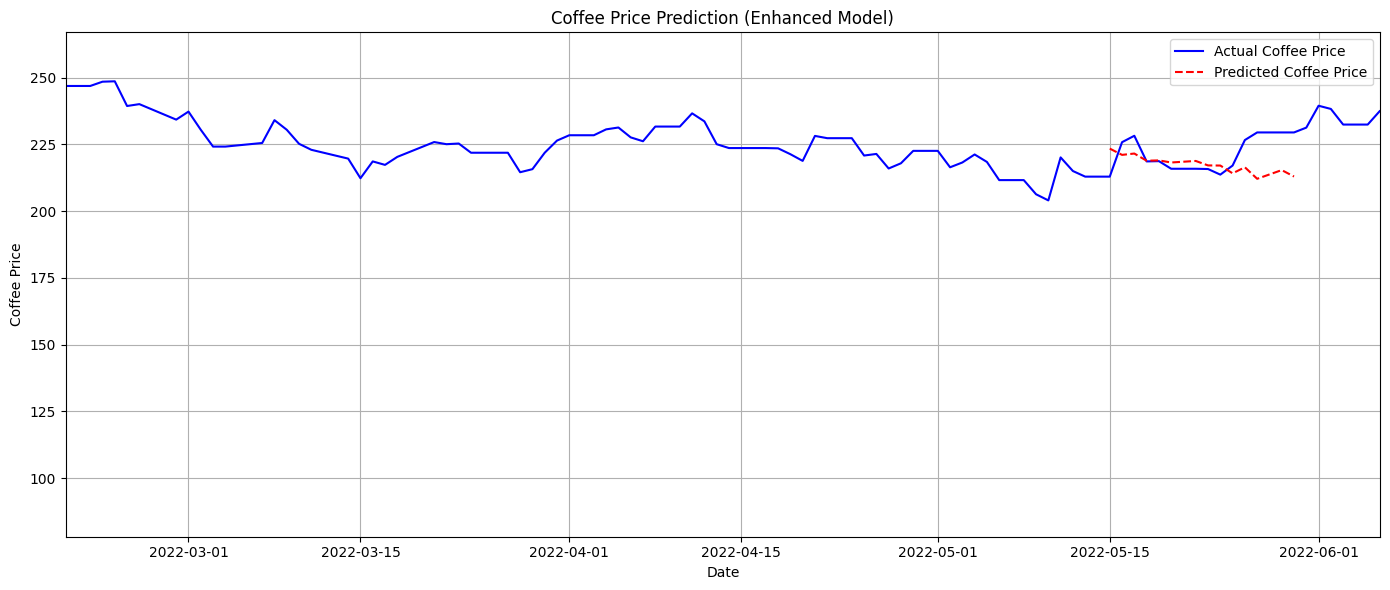

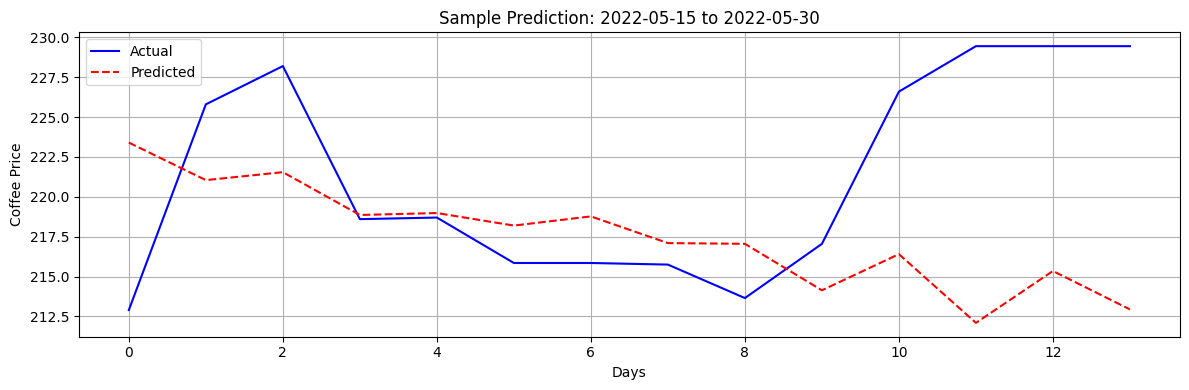

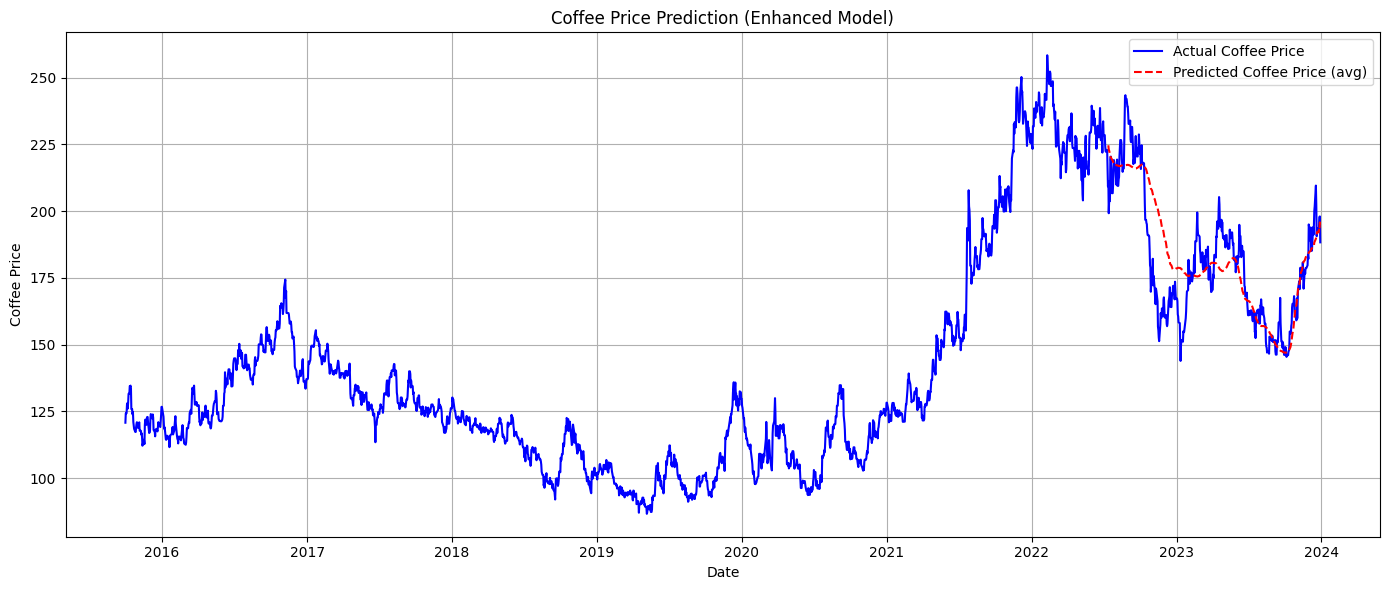

In [ ]:
# 코랩 실행을 위한 실행 코드
if __name__ == "__main__":
    # Jupyter/Colab에서 실행할 때 발생하는 인자 문제 해결
    import sys
    argv = sys.argv

    # Jupyter/Colab에서 자동으로 추가하는 -f 인자 제거
    if len(argv) > 1 and argv[1].startswith('-f'):
        sys.argv = [argv[0]] + argv[2:]  # -f 인자와 그 값 제거

    parser = argparse.ArgumentParser()
    parser.add_argument('--macro_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv',
                      help='Path to macro data')
    parser.add_argument('--climate_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv',
                      help='Path to climate data')
    parser.add_argument('--output_path', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/',
                      help='Output directory')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', type=int, default=10, help='Batch size')
    parser.add_argument('--data_window', type=int, default=50, help='Data window size')
    parser.add_argument('--future_target', type=int, default=14, help='Future prediction days')
    parser.add_argument('--hidden_size', type=int, default=100, help='LSTM hidden size')
    parser.add_argument('--scale_price', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to scale price feature (True/False)')
    parser.add_argument('--loss_fn', type=str, default='combined',
                      choices=['mse', 'huber', 'directional', 'combined'],
                      help='Loss function to use (mse, huber, directional, combined)')
    parser.add_argument('--delta', type=float, default=1.0, help='Delta parameter for Huber Loss')
    parser.add_argument('--alpha', type=float, default=0.6, help='Alpha parameter for Directional Loss')
    parser.add_argument('--mount_drive', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to mount Google Drive (Colab only)')

    try:
        args = parser.parse_args()
    except SystemExit:
        # argparse에서 오류가 발생하면 기본값으로 진행
        print("인자 파싱 오류 발생, 기본 설정으로 진행합니다.")
        class Args:
            def __init__(self):
                self.macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
                self.climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
                self.output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'
                self.epochs = 100
                self.batch_size = 10
                self.data_window = 50
                self.future_target = 14
                self.hidden_size = 100
                self.scale_price = True
                self.loss_fn = 'combined'
                self.delta = 1.0
                self.alpha = 0.6
                self.mount_drive = True
        args = Args()

    # Google Drive 마운트 (코랩에서만)
    if args.mount_drive:
        is_mounted = mount_drive()
        if not is_mounted:
            print("Note: Google Drive not mounted, using local paths")

    # 출력 디렉토리 생성
    os.makedirs(args.output_path, exist_ok=True)

    print(f"Starting main with epochs={args.epochs}, batch_size={args.batch_size}, scale_price={args.scale_price}, loss_fn={args.loss_fn}")

    # 메인 함수 실행
    forecast, model, scaler = main(
        args.macro_data,
        args.climate_data,
        args.output_path,
        data_window=args.data_window,
        future_target=args.future_target,
        batch_size=args.batch_size,
        hidden_size=args.hidden_size,
        num_epochs=args.epochs,
        scale_price=args.scale_price,
        loss_fn=args.loss_fn,
        delta=args.delta,
        alpha=args.alpha
    )

    print("Script execution complete.")

usage: colab_kernel_launcher.py [-h] [--macro_data MACRO_DATA]
                                [--climate_data CLIMATE_DATA]
                                [--output_path OUTPUT_PATH] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
                                [--data_window DATA_WINDOW]
                                [--future_target FUTURE_TARGET]
                                [--hidden_size HIDDEN_SIZE]
                                [--scale_price SCALE_PRICE]
                                [--loss_fn {mse,huber,directional,combined}]
                                [--delta DELTA] [--alpha ALPHA]
                                [--mount_drive MOUNT_DRIVE]
colab_kernel_launcher.py: error: unrecognized arguments: /root/.local/share/jupyter/runtime/kernel-86fd62a3-ba54-4057-8e79-3f58b4aee097.json


인자 파싱 오류 발생, 기본 설정으로 진행합니다.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료
Starting main with epochs=100, batch_size=10, scale_price=True, loss_fn=huber
Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)
Scaling all features including Coffee_Price...
Starting model training with 100 epochs...
Using Huber Loss with delta=1.0
Epoch [1/100], Loss: 0.0235
Epoch [10/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003
Predicting future prices...
성능 평가:
MAE: 5.6118
RMSE: 6.7276
MAPE: 2.50%
Direction Accuracy: 30.77%
Performing predictions on 415 test sequences...
Generated 415 sequence predictions
평균 13.6개의 예측이 각 날짜에 

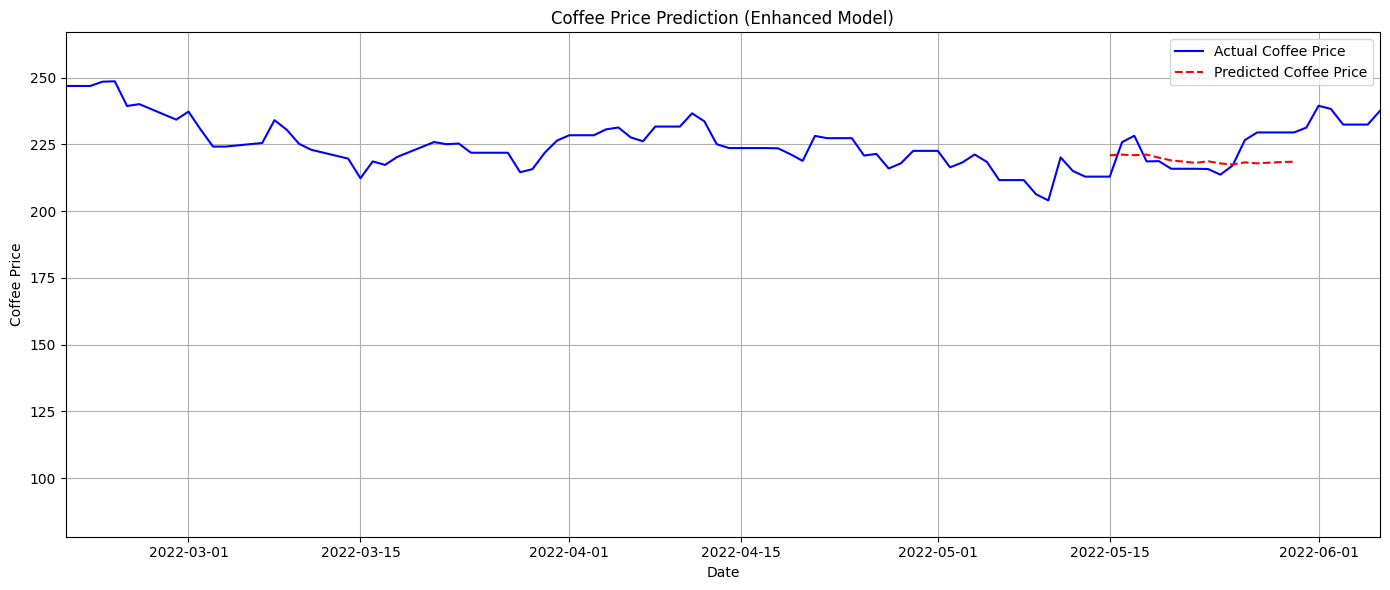

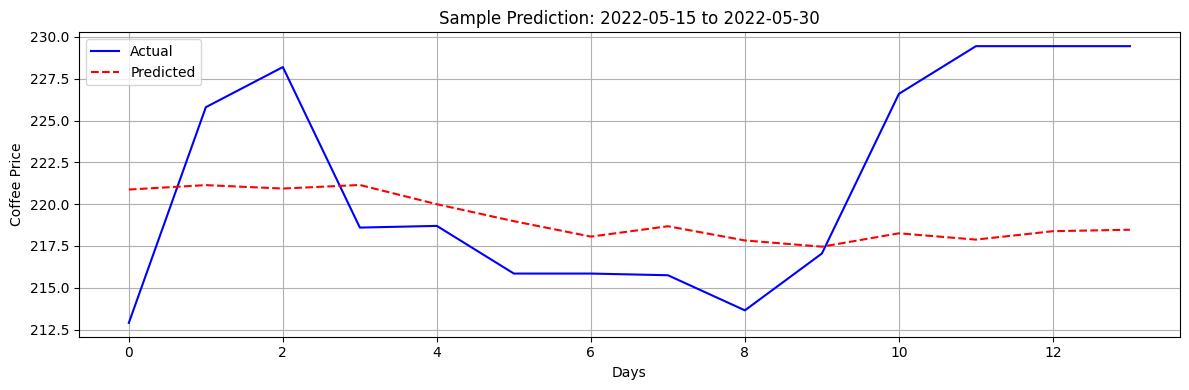

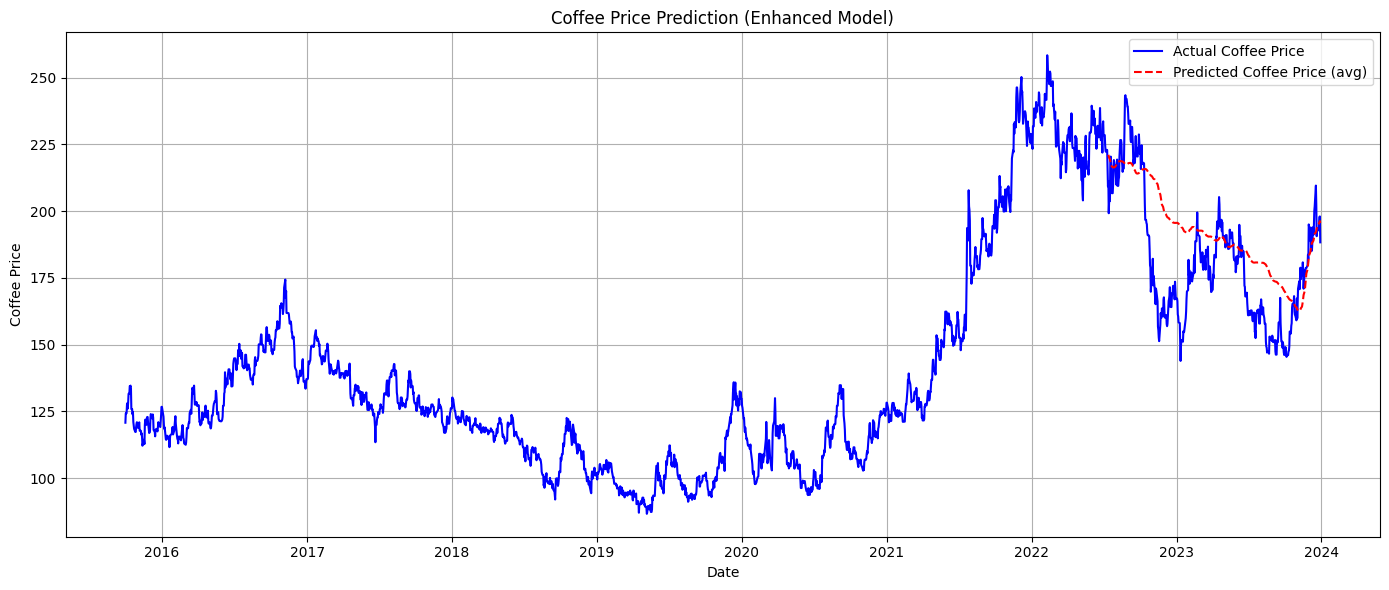

In [ ]:
# 코랩 실행을 위한 실행 코드
if __name__ == "__main__":
    # Jupyter/Colab에서 실행할 때 발생하는 인자 문제 해결
    import sys
    argv = sys.argv

    # Jupyter/Colab에서 자동으로 추가하는 -f 인자 제거
    if len(argv) > 1 and argv[1].startswith('-f'):
        sys.argv = [argv[0]] + argv[2:]  # -f 인자와 그 값 제거

    parser = argparse.ArgumentParser()
    parser.add_argument('--macro_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv',
                      help='Path to macro data')
    parser.add_argument('--climate_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv',
                      help='Path to climate data')
    parser.add_argument('--output_path', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/',
                      help='Output directory')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', type=int, default=10, help='Batch size')
    parser.add_argument('--data_window', type=int, default=50, help='Data window size')
    parser.add_argument('--future_target', type=int, default=14, help='Future prediction days')
    parser.add_argument('--hidden_size', type=int, default=100, help='LSTM hidden size')
    parser.add_argument('--scale_price', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to scale price feature (True/False)')
    parser.add_argument('--loss_fn', type=str, default='combined',
                      choices=['mse', 'huber', 'directional', 'combined'],
                      help='Loss function to use (mse, huber, directional, combined)')
    parser.add_argument('--delta', type=float, default=1.0, help='Delta parameter for Huber Loss')
    parser.add_argument('--alpha', type=float, default=0.6, help='Alpha parameter for Directional Loss')
    parser.add_argument('--mount_drive', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to mount Google Drive (Colab only)')

    try:
        args = parser.parse_args()
    except SystemExit:
        # argparse에서 오류가 발생하면 기본값으로 진행
        print("인자 파싱 오류 발생, 기본 설정으로 진행합니다.")
        class Args:
            def __init__(self):
                self.macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
                self.climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
                self.output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'
                self.epochs = 100
                self.batch_size = 10
                self.data_window = 50
                self.future_target = 14
                self.hidden_size = 100
                self.scale_price = True
                self.loss_fn = 'huber'
                self.delta = 1.0
                self.alpha = 0.6
                self.mount_drive = True
        args = Args()

    # Google Drive 마운트 (코랩에서만)
    if args.mount_drive:
        is_mounted = mount_drive()
        if not is_mounted:
            print("Note: Google Drive not mounted, using local paths")

    # 출력 디렉토리 생성
    os.makedirs(args.output_path, exist_ok=True)

    print(f"Starting main with epochs={args.epochs}, batch_size={args.batch_size}, scale_price={args.scale_price}, loss_fn={args.loss_fn}")

    # 메인 함수 실행
    forecast, model, scaler = main(
        args.macro_data,
        args.climate_data,
        args.output_path,
        data_window=args.data_window,
        future_target=args.future_target,
        batch_size=args.batch_size,
        hidden_size=args.hidden_size,
        num_epochs=args.epochs,
        scale_price=args.scale_price,
        loss_fn=args.loss_fn,
        delta=args.delta,
        alpha=args.alpha
    )

    print("Script execution complete.")

usage: colab_kernel_launcher.py [-h] [--macro_data MACRO_DATA]
                                [--climate_data CLIMATE_DATA]
                                [--output_path OUTPUT_PATH] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
                                [--data_window DATA_WINDOW]
                                [--future_target FUTURE_TARGET]
                                [--hidden_size HIDDEN_SIZE]
                                [--scale_price SCALE_PRICE]
                                [--loss_fn {mse,huber,directional,combined}]
                                [--delta DELTA] [--alpha ALPHA]
                                [--mount_drive MOUNT_DRIVE]
colab_kernel_launcher.py: error: unrecognized arguments: /root/.local/share/jupyter/runtime/kernel-86fd62a3-ba54-4057-8e79-3f58b4aee097.json


인자 파싱 오류 발생, 기본 설정으로 진행합니다.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료
Starting main with epochs=100, batch_size=10, scale_price=True, loss_fn=huber
Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)
Scaling all features including Coffee_Price...
Starting model training with 100 epochs...
Using Huber Loss with delta=1.0
Epoch [1/100], Loss: 0.0188
Epoch [10/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003
Predicting future prices...
성능 평가:
MAE: 6.5673
RMSE: 8.2034
MAPE: 2.92%
Direction Accuracy: 15.38%
Performing predictions on 415 test sequences...
Generated 415 sequence predictions
평균 13.6개의 예측이 각 날짜에 

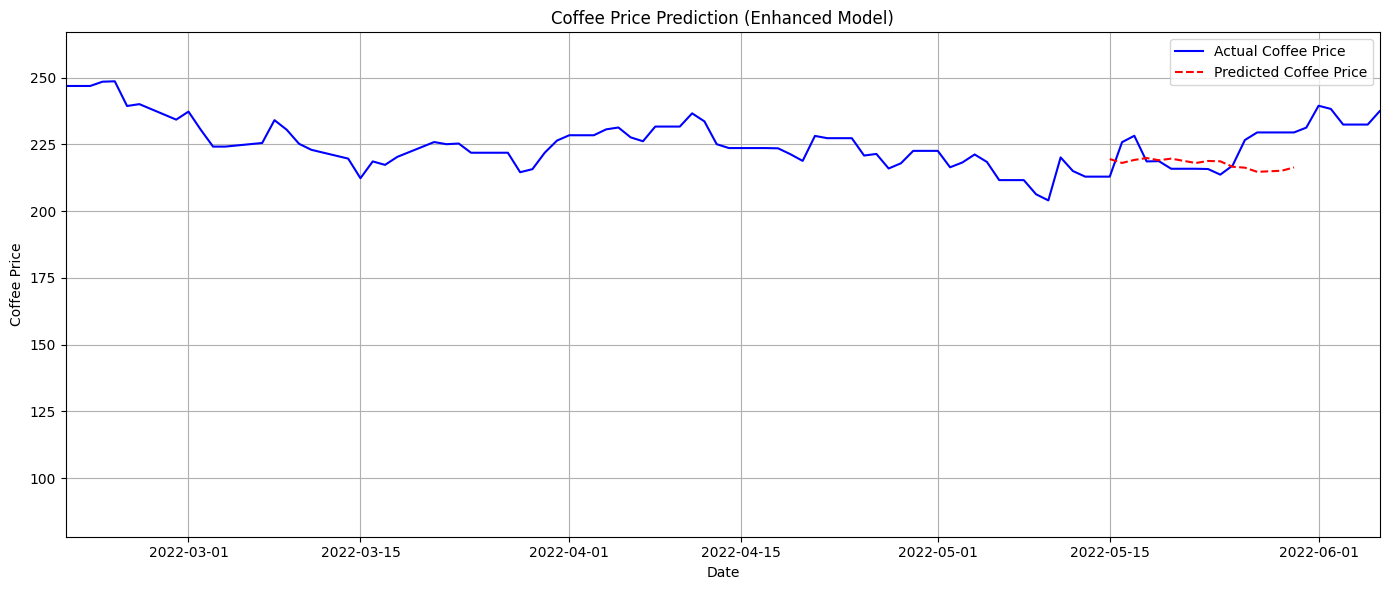

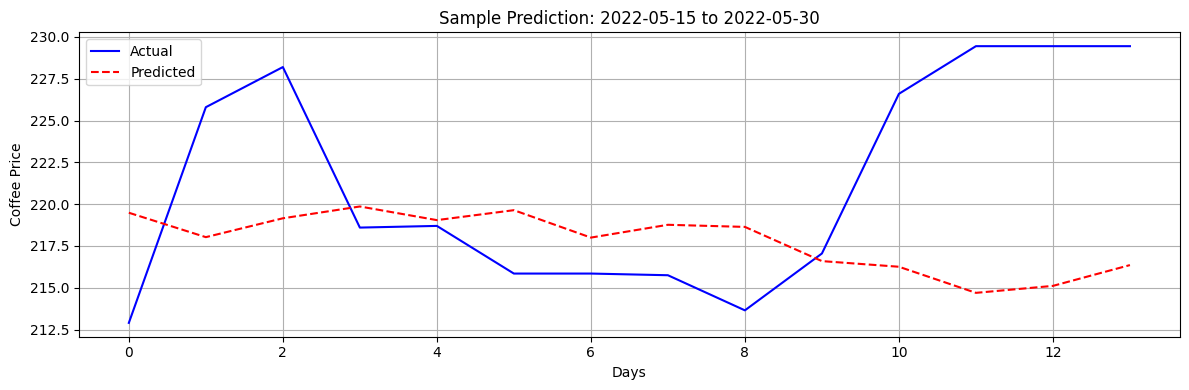

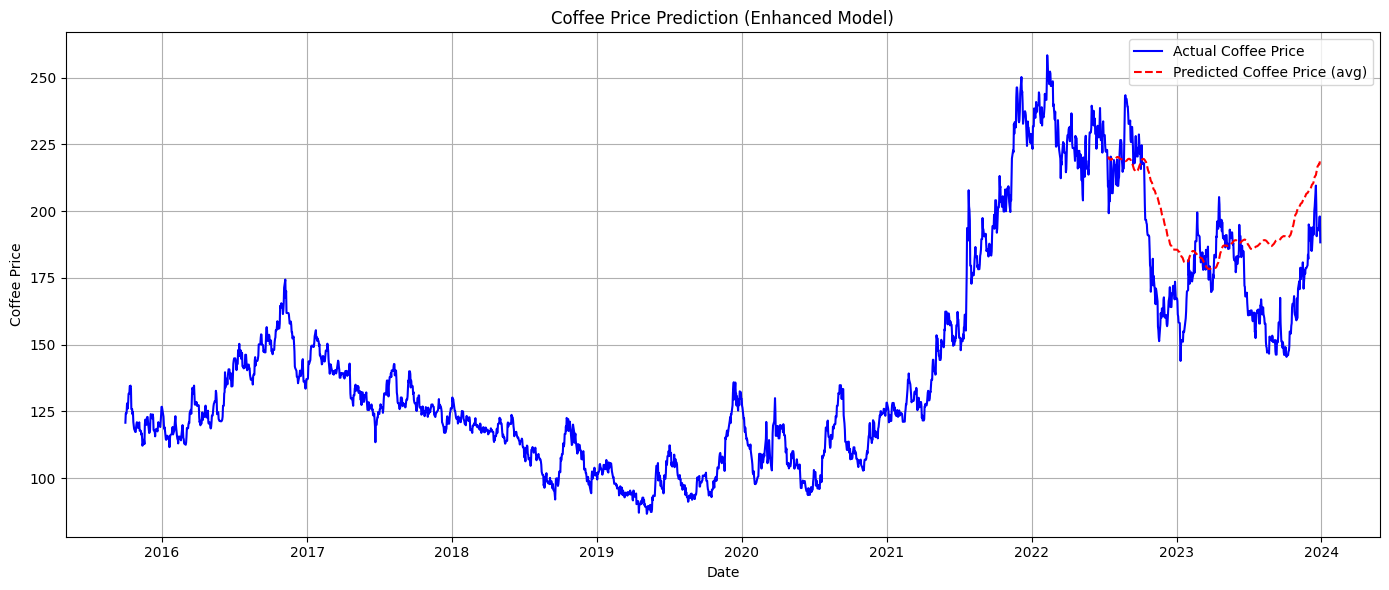

In [ ]:
# 코랩 실행을 위한 실행 코드
if __name__ == "__main__":
    # Jupyter/Colab에서 실행할 때 발생하는 인자 문제 해결
    import sys
    argv = sys.argv

    # Jupyter/Colab에서 자동으로 추가하는 -f 인자 제거
    if len(argv) > 1 and argv[1].startswith('-f'):
        sys.argv = [argv[0]] + argv[2:]  # -f 인자와 그 값 제거

    parser = argparse.ArgumentParser()
    parser.add_argument('--macro_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv',
                      help='Path to macro data')
    parser.add_argument('--climate_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv',
                      help='Path to climate data')
    parser.add_argument('--output_path', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/',
                      help='Output directory')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', type=int, default=10, help='Batch size')
    parser.add_argument('--data_window', type=int, default=50, help='Data window size')
    parser.add_argument('--future_target', type=int, default=14, help='Future prediction days')
    parser.add_argument('--hidden_size', type=int, default=100, help='LSTM hidden size')
    parser.add_argument('--scale_price', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to scale price feature (True/False)')
    parser.add_argument('--loss_fn', type=str, default='directional',
                      choices=['mse', 'huber', 'directional', 'combined'],
                      help='Loss function to use (mse, huber, directional, combined)')
    parser.add_argument('--delta', type=float, default=1.0, help='Delta parameter for Huber Loss')
    parser.add_argument('--alpha', type=float, default=0.6, help='Alpha parameter for Directional Loss')
    parser.add_argument('--mount_drive', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to mount Google Drive (Colab only)')

    try:
        args = parser.parse_args()
    except SystemExit:
        # argparse에서 오류가 발생하면 기본값으로 진행
        print("인자 파싱 오류 발생, 기본 설정으로 진행합니다.")
        class Args:
            def __init__(self):
                self.macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
                self.climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
                self.output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'
                self.epochs = 100
                self.batch_size = 10
                self.data_window = 50
                self.future_target = 14
                self.hidden_size = 100
                self.scale_price = True
                self.loss_fn = 'huber'
                self.delta = 1.0
                self.alpha = 0.6
                self.mount_drive = True
        args = Args()

    # Google Drive 마운트 (코랩에서만)
    if args.mount_drive:
        is_mounted = mount_drive()
        if not is_mounted:
            print("Note: Google Drive not mounted, using local paths")

    # 출력 디렉토리 생성
    os.makedirs(args.output_path, exist_ok=True)

    print(f"Starting main with epochs={args.epochs}, batch_size={args.batch_size}, scale_price={args.scale_price}, loss_fn={args.loss_fn}")

    # 메인 함수 실행
    forecast, model, scaler = main(
        args.macro_data,
        args.climate_data,
        args.output_path,
        data_window=args.data_window,
        future_target=args.future_target,
        batch_size=args.batch_size,
        hidden_size=args.hidden_size,
        num_epochs=args.epochs,
        scale_price=args.scale_price,
        loss_fn=args.loss_fn,
        delta=args.delta,
        alpha=args.alpha
    )

    print("Script execution complete.")

usage: colab_kernel_launcher.py [-h] [--macro_data MACRO_DATA]
                                [--climate_data CLIMATE_DATA]
                                [--output_path OUTPUT_PATH] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
                                [--data_window DATA_WINDOW]
                                [--future_target FUTURE_TARGET]
                                [--hidden_size HIDDEN_SIZE]
                                [--scale_price SCALE_PRICE]
                                [--loss_fn {mse,huber,directional,combined}]
                                [--delta DELTA] [--alpha ALPHA]
                                [--mount_drive MOUNT_DRIVE]
colab_kernel_launcher.py: error: unrecognized arguments: /root/.local/share/jupyter/runtime/kernel-86fd62a3-ba54-4057-8e79-3f58b4aee097.json


인자 파싱 오류 발생, 기본 설정으로 진행합니다.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료
Starting main with epochs=100, batch_size=10, scale_price=True, loss_fn=huber
Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)
Scaling all features including Coffee_Price...
Starting model training with 100 epochs...
Using Huber Loss with delta=1.0
Epoch [1/100], Loss: 0.0210
Epoch [10/100], Loss: 0.0008
Epoch [20/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Predicting future prices...
성능 평가:
MAE: 6.2130
RMSE: 7.0277
MAPE: 2.79%
Direction Accuracy: 38.46%
Performing predictions on 415 test sequences...
Generated 415 sequence predictions
평균 13.6개의 예측이 각 날짜에 

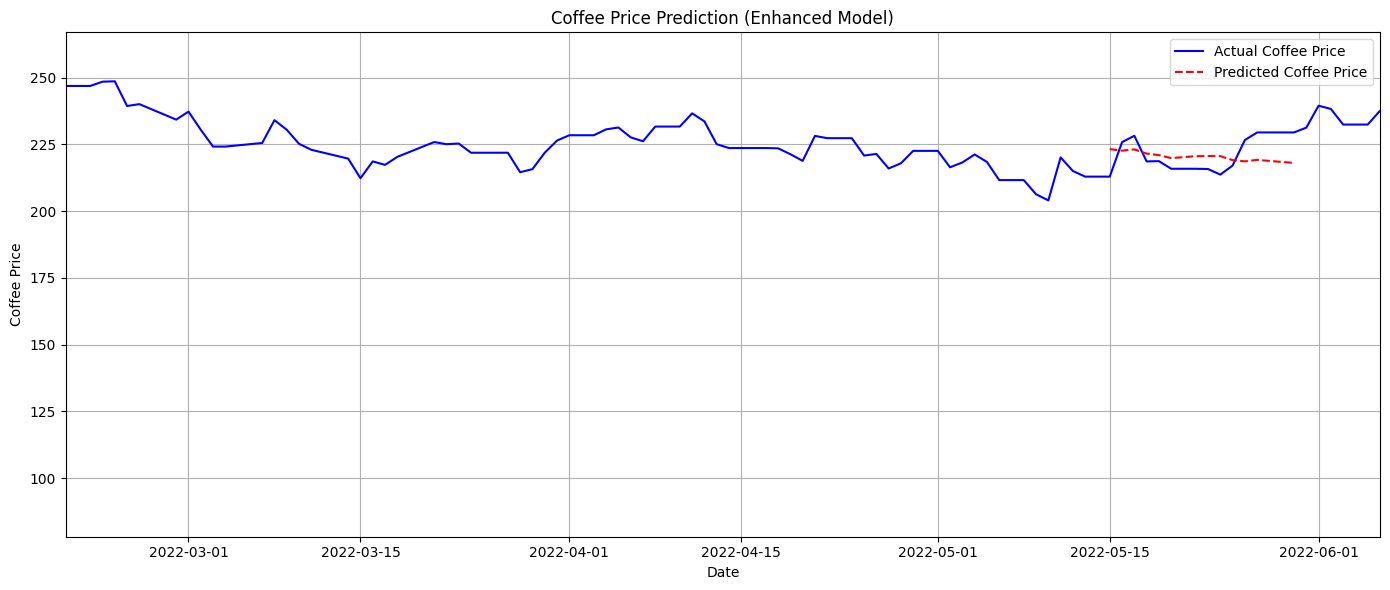

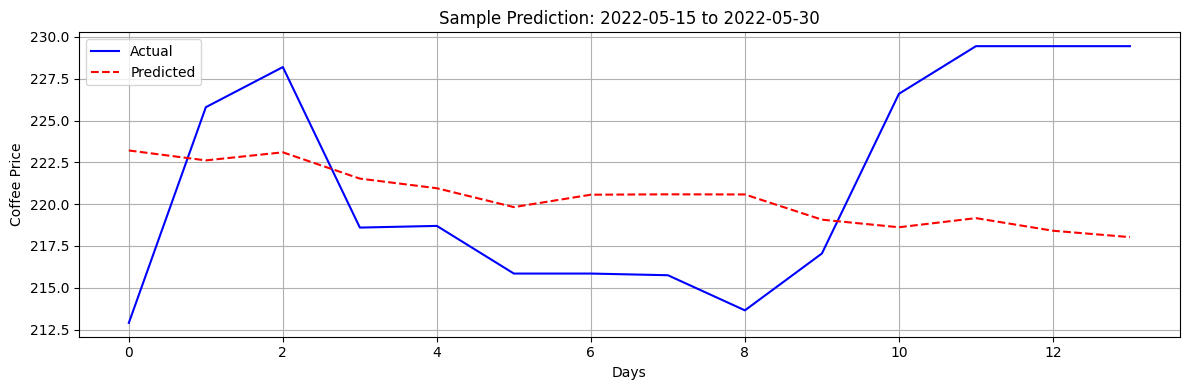

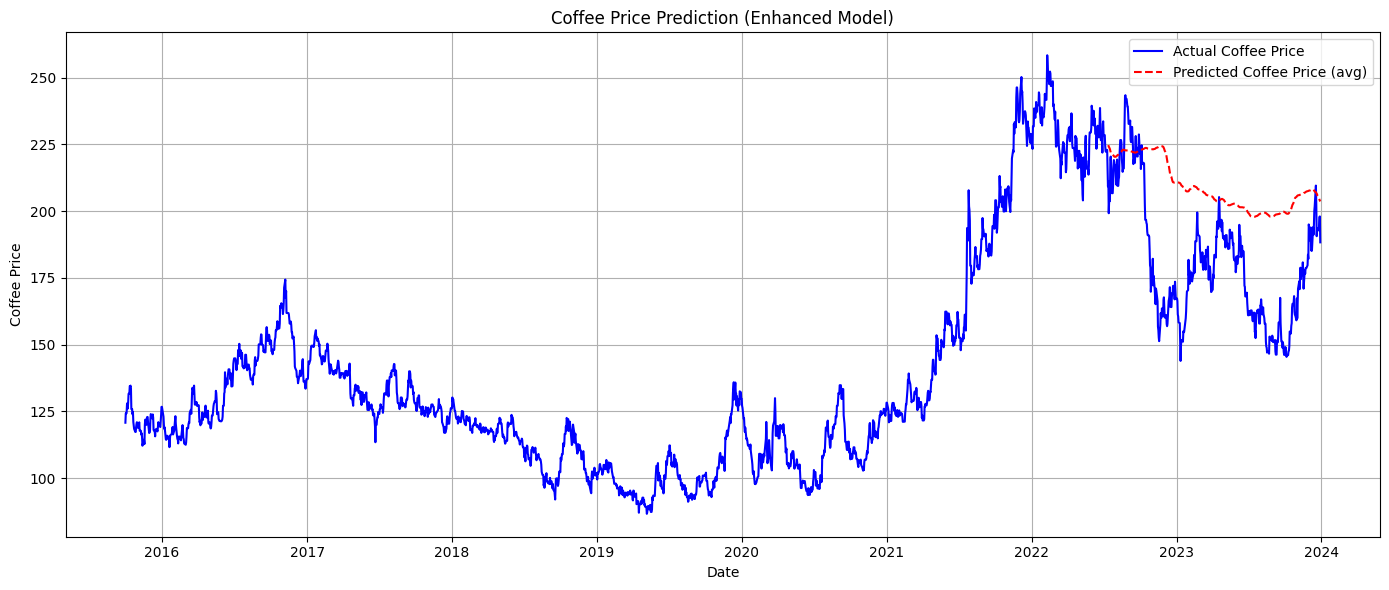

In [ ]:
# 코랩 실행을 위한 실행 코드
if __name__ == "__main__":
    # Jupyter/Colab에서 실행할 때 발생하는 인자 문제 해결
    import sys
    argv = sys.argv

    # Jupyter/Colab에서 자동으로 추가하는 -f 인자 제거
    if len(argv) > 1 and argv[1].startswith('-f'):
        sys.argv = [argv[0]] + argv[2:]  # -f 인자와 그 값 제거

    parser = argparse.ArgumentParser()
    parser.add_argument('--macro_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv',
                      help='Path to macro data')
    parser.add_argument('--climate_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv',
                      help='Path to climate data')
    parser.add_argument('--output_path', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/',
                      help='Output directory')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', type=int, default=10, help='Batch size')
    parser.add_argument('--data_window', type=int, default=50, help='Data window size')
    parser.add_argument('--future_target', type=int, default=14, help='Future prediction days')
    parser.add_argument('--hidden_size', type=int, default=100, help='LSTM hidden size')
    parser.add_argument('--scale_price', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to scale price feature (True/False)')
    parser.add_argument('--loss_fn', type=str, default='mse',
                      choices=['mse', 'huber', 'directional', 'combined'],
                      help='Loss function to use (mse, huber, directional, combined)')
    parser.add_argument('--delta', type=float, default=1.0, help='Delta parameter for Huber Loss')
    parser.add_argument('--alpha', type=float, default=0.6, help='Alpha parameter for Directional Loss')
    parser.add_argument('--mount_drive', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to mount Google Drive (Colab only)')

    try:
        args = parser.parse_args()
    except SystemExit:
        # argparse에서 오류가 발생하면 기본값으로 진행
        print("인자 파싱 오류 발생, 기본 설정으로 진행합니다.")
        class Args:
            def __init__(self):
                self.macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
                self.climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
                self.output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'
                self.epochs = 100
                self.batch_size = 10
                self.data_window = 50
                self.future_target = 14
                self.hidden_size = 100
                self.scale_price = True
                self.loss_fn = 'huber'
                self.delta = 1.0
                self.alpha = 0.6
                self.mount_drive = True
        args = Args()

    # Google Drive 마운트 (코랩에서만)
    if args.mount_drive:
        is_mounted = mount_drive()
        if not is_mounted:
            print("Note: Google Drive not mounted, using local paths")

    # 출력 디렉토리 생성
    os.makedirs(args.output_path, exist_ok=True)

    print(f"Starting main with epochs={args.epochs}, batch_size={args.batch_size}, scale_price={args.scale_price}, loss_fn={args.loss_fn}")

    # 메인 함수 실행
    forecast, model, scaler = main(
        args.macro_data,
        args.climate_data,
        args.output_path,
        data_window=args.data_window,
        future_target=args.future_target,
        batch_size=args.batch_size,
        hidden_size=args.hidden_size,
        num_epochs=args.epochs,
        scale_price=args.scale_price,
        loss_fn=args.loss_fn,
        delta=args.delta,
        alpha=args.alpha
    )

    print("Script execution complete.")

### 최적의 손실 함수(combinde)

usage: colab_kernel_launcher.py [-h] [--macro_data MACRO_DATA]
                                [--climate_data CLIMATE_DATA]
                                [--output_path OUTPUT_PATH] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
                                [--data_window DATA_WINDOW]
                                [--future_target FUTURE_TARGET]
                                [--hidden_size HIDDEN_SIZE]
                                [--scale_price SCALE_PRICE]
                                [--loss_fn {mse,huber,directional,combined}]
                                [--delta DELTA] [--alpha ALPHA]
                                [--mount_drive MOUNT_DRIVE]
colab_kernel_launcher.py: error: unrecognized arguments: /root/.local/share/jupyter/runtime/kernel-86fd62a3-ba54-4057-8e79-3f58b4aee097.json


인자 파싱 오류 발생, 기본 설정으로 진행합니다.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료
Starting main with epochs=100, batch_size=10, scale_price=True, loss_fn=combined
Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)
Scaling all features including Coffee_Price...
Starting model training with 100 epochs...
Using Combined Loss
Epoch [1/100], Loss: 0.2791
Epoch [10/100], Loss: 0.2353
Epoch [20/100], Loss: 0.2346
Epoch [30/100], Loss: 0.2327
Epoch [40/100], Loss: 0.2313
Epoch [50/100], Loss: 0.2281
Epoch [60/100], Loss: 0.2249
Epoch [70/100], Loss: 0.2226
Epoch [80/100], Loss: 0.2215
Epoch [90/100], Loss: 0.2213
Epoch [100/100], Loss: 0.2183
Predicting future prices...
성능 평가:
MAE: 6.6610
RMSE: 8.0735
MAPE: 2.98%
Direction Accuracy: 23.08%
Performing predictions on 415 test sequences...
Generated 415 sequence predictions
평균 13.6개의 예측이 각 날짜에 겹침
Predic

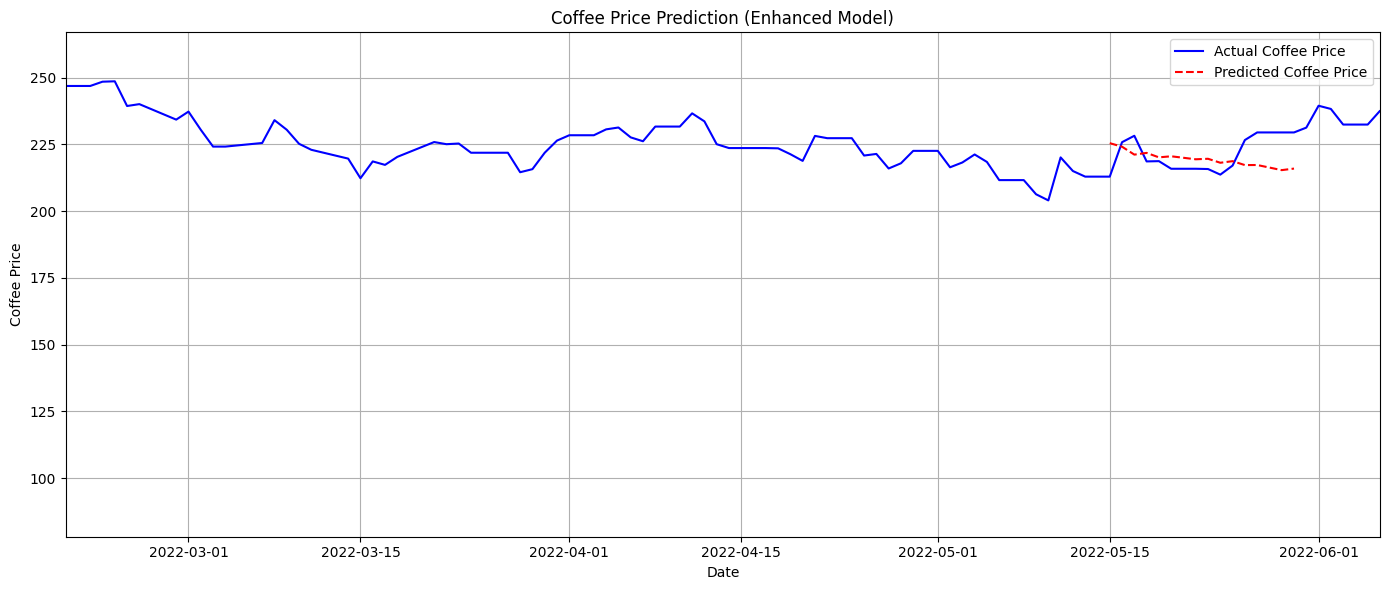

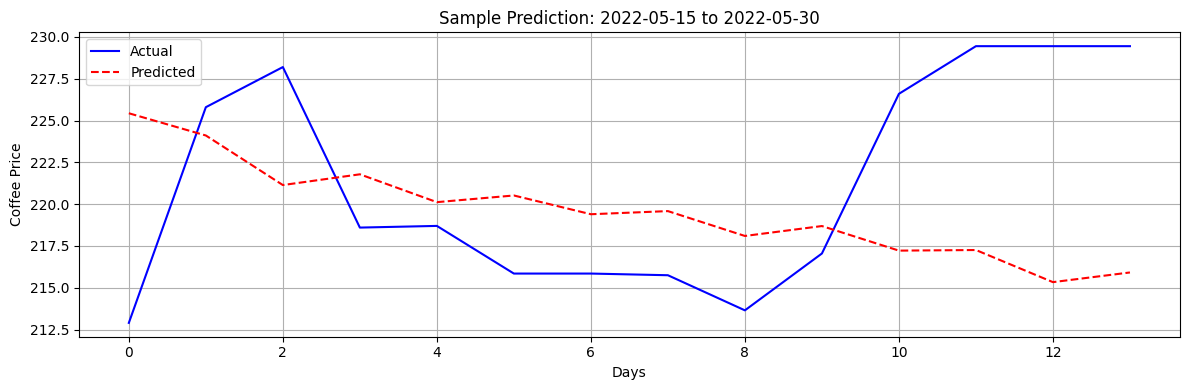

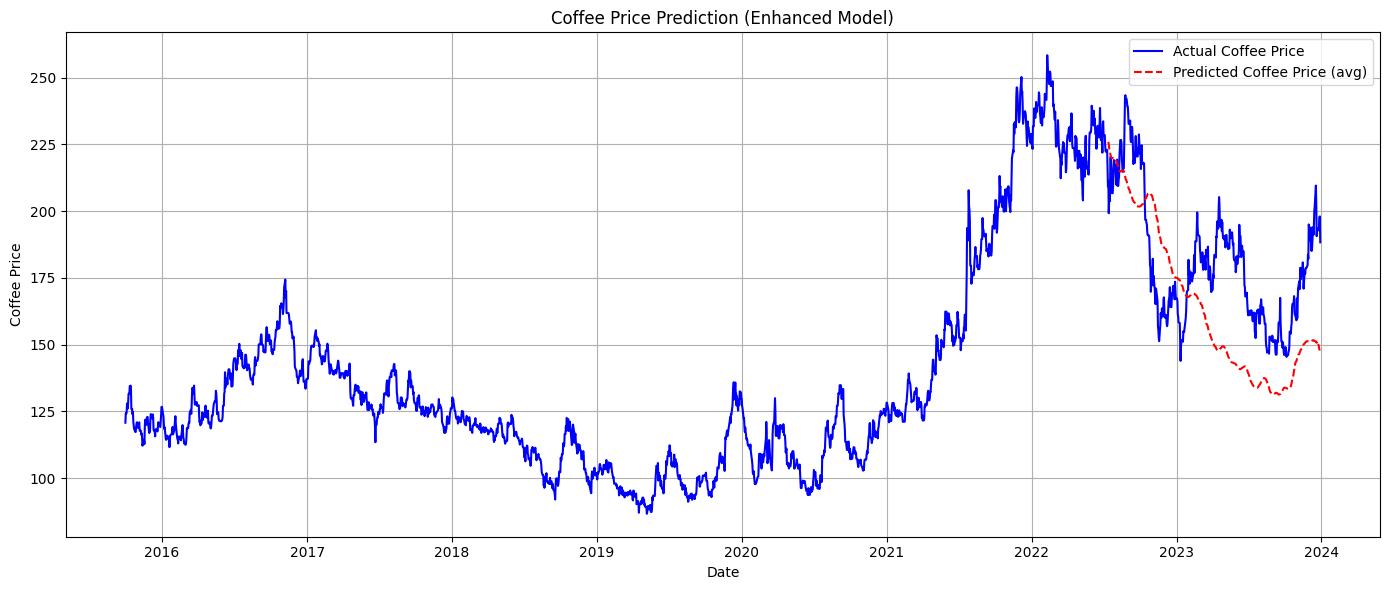

In [ ]:
# 코랩 실행을 위한 실행 코드
if __name__ == "__main__":
    # Jupyter/Colab에서 실행할 때 발생하는 인자 문제 해결
    import sys
    argv = sys.argv

    # Jupyter/Colab에서 자동으로 추가하는 -f 인자 제거
    if len(argv) > 1 and argv[1].startswith('-f'):
        sys.argv = [argv[0]] + argv[2:]  # -f 인자와 그 값 제거

    parser = argparse.ArgumentParser()
    parser.add_argument('--macro_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv',
                      help='Path to macro data')
    parser.add_argument('--climate_data', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv',
                      help='Path to climate data')
    parser.add_argument('--output_path', type=str,
                      default='/content/drive/MyDrive/Colab Notebooks/univ/capstone/',
                      help='Output directory')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', type=int, default=10, help='Batch size')
    parser.add_argument('--data_window', type=int, default=50, help='Data window size')
    parser.add_argument('--future_target', type=int, default=14, help='Future prediction days')
    parser.add_argument('--hidden_size', type=int, default=100, help='LSTM hidden size')
    parser.add_argument('--scale_price', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to scale price feature (True/False)')
    parser.add_argument('--loss_fn', type=str, default='combined',
                      choices=['mse', 'huber', 'directional', 'combined'],
                      help='Loss function to use (mse, huber, directional, combined)')
    parser.add_argument('--delta', type=float, default=1.0, help='Delta parameter for Huber Loss')
    parser.add_argument('--alpha', type=float, default=0.6, help='Alpha parameter for Directional Loss')
    parser.add_argument('--mount_drive', type=lambda x: (str(x).lower() == 'true'), default=True,
                      help='Whether to mount Google Drive (Colab only)')

    try:
        args = parser.parse_args()
    except SystemExit:
        # argparse에서 오류가 발생하면 기본값으로 진행
        print("인자 파싱 오류 발생, 기본 설정으로 진행합니다.")
        class Args:
            def __init__(self):
                self.macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
                self.climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
                self.output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'
                self.epochs = 100
                self.batch_size = 10
                self.data_window = 50
                self.future_target = 14
                self.hidden_size = 100
                self.scale_price = True
                self.loss_fn = 'combined'
                self.delta = 1.0
                self.alpha = 0.6
                self.mount_drive = True
        args = Args()

    # Google Drive 마운트 (코랩에서만)
    if args.mount_drive:
        is_mounted = mount_drive()
        if not is_mounted:
            print("Note: Google Drive not mounted, using local paths")

    # 출력 디렉토리 생성
    os.makedirs(args.output_path, exist_ok=True)

    print(f"Starting main with epochs={args.epochs}, batch_size={args.batch_size}, scale_price={args.scale_price}, loss_fn={args.loss_fn}")

    # 메인 함수 실행
    forecast, model, scaler = main(
        args.macro_data,
        args.climate_data,
        args.output_path,
        data_window=args.data_window,
        future_target=args.future_target,
        batch_size=args.batch_size,
        hidden_size=args.hidden_size,
        num_epochs=args.epochs,
        scale_price=args.scale_price,
        loss_fn=args.loss_fn,
        delta=args.delta,
        alpha=args.alpha
    )

    print("Script execution complete.")

In [ ]:
#--------------------------- 부스팅 기반 모델 구현 ---------------------------#

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

class BoostingTimeSeriesModel:
    """
    시계열 예측을 위한 부스팅 기반 모델 클래스

    여러 개의 약한 학습기(weak learner)를 순차적으로 학습시켜
    각각이 이전 모델들의 오차를 학습하도록 설계됨
    """

    def __init__(self, base_model_class, n_estimators=3, learning_rate=0.1,
                 device='cpu', **model_params):
        """
        부스팅 모델 초기화

        Args:
            base_model_class: 기본 모델 클래스 (AttentionLSTMModel 등)
            n_estimators (int): 부스팅에 사용할 모델 수
            learning_rate (float): 부스팅 학습률 (각 모델의 기여도 조절)
            device (str): 사용할 디바이스 ('cpu' 또는 'cuda')
            **model_params: 기본 모델에 전달할 추가 매개변수
        """
        self.base_model_class = base_model_class
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.device = device
        self.model_params = model_params
        self.models = []
        self.scalers = []  # 각 단계마다 잔차의 스케일러 저장

    def fit(self, train_loader, num_epochs=50, loss_fn='mse', verbose=True):
        """
        부스팅 모델 학습

        Args:
            train_loader (DataLoader): 훈련 데이터 로더
            num_epochs (int): 각 모델별 훈련 에폭 수
            loss_fn (str): 손실 함수 유형
            verbose (bool): 상세 출력 여부

        Returns:
            self: 학습된 모델
        """
        # 전체 데이터셋에서 데이터 추출
        X_all, y_all = self._extract_data_from_loader(train_loader)

        # 현재 타겟 설정 (처음에는 원본 타겟)
        current_targets = y_all.clone()

        for i in range(self.n_estimators):
            if verbose:
                print(f"\n===== Training Boosting Model {i+1}/{self.n_estimators} =====")

            # i번째 모델 초기화
            model = self.base_model_class(**self.model_params).to(self.device)

            # 현재 타겟으로 데이터셋 생성
            current_dataset = TensorDataset(X_all, current_targets)
            current_loader = DataLoader(
                current_dataset,
                batch_size=train_loader.batch_size,
                shuffle=True
            )

            # 현재 모델 학습
            self._train_single_model(model, current_loader, num_epochs, loss_fn, verbose)

            # 학습된 모델을 목록에 추가
            self.models.append(model)

            # 예측 및 잔차 계산
            model.eval()
            with torch.no_grad():
                predictions, _ = model(X_all)

            # 잔차 계산 (현재 타겟 - 예측)
            residuals = current_targets - predictions

            # 다음 모델을 위한 타겟 업데이트 (잔차가 새로운 타겟)
            current_targets = residuals

            if verbose:
                # 현재까지 앙상블 성능 평가
                ensemble_preds = self._get_ensemble_predictions(X_all)
                mse = torch.mean((ensemble_preds - y_all) ** 2).item()
                mae = torch.mean(torch.abs(ensemble_preds - y_all)).item()
                print(f"After model {i+1}, MSE: {mse:.4f}, MAE: {mae:.4f}")

        return self

    def _extract_data_from_loader(self, data_loader):
        """
        DataLoader에서 전체 데이터를 추출

        Args:
            data_loader (DataLoader): 데이터 로더

        Returns:
            tuple: (X_all, y_all) 전체 입력과 타겟 텐서
        """
        X_batches, y_batches = [], []

        for X_batch, y_batch in data_loader:
            X_batches.append(X_batch)
            y_batches.append(y_batch)

        X_all = torch.cat(X_batches, dim=0).to(self.device)
        y_all = torch.cat(y_batches, dim=0).to(self.device)

        return X_all, y_all

    def _train_single_model(self, model, data_loader, num_epochs, loss_fn, verbose):
        """
        부스팅의 단일 모델 학습

        Args:
            model (nn.Module): 학습할 모델
            data_loader (DataLoader): 학습 데이터 로더
            num_epochs (int): 학습 에폭 수
            loss_fn (str): 손실 함수 유형
            verbose (bool): 상세 출력 여부

        Returns:
            nn.Module: 학습된 모델
        """
        # 손실 함수 선택
        if loss_fn.lower() == 'huber':
            criterion = HuberLoss(delta=1.0)
        elif loss_fn.lower() == 'directional':
            criterion = DirectionalLoss(alpha=0.6)
        elif loss_fn.lower() == 'combined':
            criterion = CombinedLoss()
        else:
            criterion = nn.MSELoss()

        # 옵티마이저 설정
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        # 학습 루프
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                # 그래디언트 초기화
                optimizer.zero_grad()

                # 순전파
                y_pred, _ = model(X_batch)

                # 손실 계산
                loss = criterion(y_pred, y_batch)

                # 역전파
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                optimizer.step()

                epoch_loss += loss.item()

            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

        return model

    def predict(self, X):
        """
        앙상블 모델을 사용한 예측

        Args:
            X (torch.Tensor): 입력 텐서

        Returns:
            torch.Tensor: 예측값
        """
        # 모델이 학습되었는지 확인
        if len(self.models) == 0:
            raise ValueError("Model has not been trained yet.")

        return self._get_ensemble_predictions(X)

    def _get_ensemble_predictions(self, X):
        """
        모든 모델의 예측값을 결합하여 앙상블 예측 생성

        Args:
            X (torch.Tensor): 입력 텐서

        Returns:
            torch.Tensor: 앙상블 예측값
        """
        ensemble_pred = torch.zeros(X.size(0), self.models[0].target_size).to(self.device)

        # 각 모델의 예측값 계산
        for i, model in enumerate(self.models):
            model.eval()
            with torch.no_grad():
                model_pred, _ = model(X)

            # 첫 번째 모델은 원래 타겟 예측, 나머지는 잔차 예측
            if i == 0:
                ensemble_pred = model_pred
            else:
                ensemble_pred += self.learning_rate * model_pred

        return ensemble_pred


class ResidualBoostingLSTM(nn.Module):
    """
    잔차 학습을 위한 부스팅 LSTM 모델

    단일 모델 내에서 여러 단계의 LSTM을 계층적으로 구성하여
    각 단계가 이전 단계의 잔차를 학습하도록 구현된 모델
    """

    def __init__(self, input_size, hidden_size=100, num_layers=2,
                 n_stages=3, target_size=14, dropout=0.2):
        """
        ResidualBoostingLSTM 초기화

        Args:
            input_size (int): 입력 특성 차원
            hidden_size (int): LSTM 은닉 상태 차원
            num_layers (int): 각 LSTM 단계의 층 수
            n_stages (int): 부스팅 단계 수
            target_size (int): 예측할 미래 시점 수
            dropout (float): 드롭아웃 비율
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_stages = n_stages
        self.target_size = target_size

        # 각 부스팅 단계별 LSTM 정의
        self.lstm_stages = nn.ModuleList([
            nn.LSTM(
                input_size=input_size if i == 0 else hidden_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout,
                batch_first=True
            ) for i in range(n_stages)
        ])

        # 각 부스팅 단계별 어텐션 정의
        self.attention_stages = nn.ModuleList([
            EntmaxAttention(hidden_size) for _ in range(n_stages)
        ])

        # 각 부스팅 단계별 예측 헤드
        self.predictors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, target_size)
            ) for _ in range(n_stages)
        ])

        # 부스팅 단계별 가중치 (학습 가능)
        self.stage_weights = nn.Parameter(torch.ones(n_stages) / n_stages)

    def forward(self, x):
        """
        순전파 수행

        Args:
            x (torch.Tensor): 입력 데이터 (batch_size, seq_len, input_size)

        Returns:
            tuple: (predictions, attention_weights)
                - predictions: 앙상블 예측값
                - attention_weights: 각 단계별 어텐션 가중치
        """
        batch_size = x.size(0)
        stage_predictions = []
        attention_weights = []

        # 첫 번째 입력은 원본 데이터
        current_input = x

        # 누적 예측값 (앙상블에 사용)
        accumulated_pred = None

        for i in range(self.n_stages):
            # i번째 단계 LSTM 계산
            lstm_out, _ = self.lstm_stages[i](current_input)

            # 어텐션 적용
            context, weights = self.attention_stages[i](lstm_out)
            attention_weights.append(weights)

            # 현재 단계 예측
            stage_pred = self.predictors[i](context)
            stage_predictions.append(stage_pred)

            # 누적 예측값 업데이트
            if accumulated_pred is None:
                accumulated_pred = stage_pred
            else:
                accumulated_pred = accumulated_pred + stage_pred

            # 다음 단계를 위한 입력 준비
            # 마지막 단계가 아니면 다음 단계의 입력을 준비
            if i < self.n_stages - 1:
                # 원본 시퀀스의 LSTM 출력을 다음 단계의 입력으로 사용
                current_input = lstm_out

        # 학습 가능한 가중치를 사용하여 각 단계 예측을 결합
        normalized_weights = F.softmax(self.stage_weights, dim=0)

        final_pred = torch.zeros_like(stage_predictions[0]).to(x.device)
        for i, pred in enumerate(stage_predictions):
            final_pred += normalized_weights[i] * pred

        return final_pred, attention_weights


class SequentialBoostingPredictor:
    """
    여러 모델을 순차적으로 적용하여 예측하는 클래스

    각 모델은 특정 패턴(추세, 계절성, 잔차 등)을 학습하며,
    이전 모델의 오차를 다음 모델이 학습하는 방식으로 동작
    """

    def __init__(self, models, learning_rates=None):
        """
        SequentialBoostingPredictor 초기화

        Args:
            models (list): 사용할 모델 리스트
            learning_rates (list): 각 모델의 학습률 리스트
        """
        self.models = models
        if learning_rates is None:
            self.learning_rates = [1.0] * len(models)
        else:
            self.learning_rates = learning_rates

    def predict(self, X_input, device='cpu'):
      """
      순차적 부스팅 예측 수행

      Args:
          X_input (torch.Tensor): 입력 데이터
          device (str): 사용할 디바이스

      Returns:
          torch.Tensor: 최종 예측값
      """
      X = X_input.to(device)
      final_pred = None

      for i, model in enumerate(self.models):
          # 여기가 중요함 - 확실하게 eval 모드로 설정
          model.eval()
          rate = self.learning_rates[i]

          # 반드시 no_grad 컨텍스트 내에서 실행
          with torch.no_grad():
              # 각 모델 예측
              if i == 0:
                  # 첫 번째 모델은 원본 데이터로 예측
                  pred, _ = model(X)
                  final_pred = pred
              else:
                  # 이후 모델들은 이전 잔차로 예측
                  pred, _ = model(X)
                  final_pred = final_pred + rate * pred

      return final_pred

    def fit_sequential(self, train_loader, num_epochs=50, device='cpu'):
      """
      모델을 순차적으로 학습

      Args:
          train_loader (DataLoader): 훈련 데이터 로더
          num_epochs (int): 훈련 에폭 수
          device (str): 사용할 디바이스

      Returns:
          self: 학습된 모델
      """
      # 데이터 추출
      X_all, y_all = [], []
      for X_batch, y_batch in train_loader:
          X_all.append(X_batch)
          y_all.append(y_batch)

      X_all = torch.cat(X_all, dim=0).to(device)
      y_all = torch.cat(y_all, dim=0).to(device)

      # 현재 타겟 값 (첫 모델은 원본 타겟으로 학습)
      current_target = y_all.clone()

      for i, model in enumerate(self.models):
          print(f"\n===== Training Sequential Model {i+1}/{len(self.models)} =====")

          # 현재 타겟으로 데이터셋 생성
          current_dataset = TensorDataset(X_all, current_target)
          current_loader = DataLoader(
              current_dataset,
              batch_size=train_loader.batch_size,
              shuffle=True
          )

          # 현재 모델 학습
          criterion = nn.MSELoss()
          optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

          for epoch in range(num_epochs):
              epoch_loss = 0.0

              for X_batch, y_batch in current_loader:
                  X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                  # 그래디언트 초기화
                  optimizer.zero_grad()

                  # 순전파
                  y_pred, _ = model(X_batch)

                  # 손실 계산
                  loss = criterion(y_pred, y_batch)

                  # 역전파
                  loss.backward()
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                  optimizer.step()

                  epoch_loss += loss.item()

              if (epoch + 1) % 10 == 0:
                  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(current_loader):.4f}")

          # 현재 모델로 예측
          model.eval()
          with torch.no_grad():
              current_pred, _ = model(X_all)

          # 다음 모델을 위한 잔차 계산
          if i < len(self.models) - 1:
              # 예측 전에 모든 모델을 eval 모드로 설정
              for model in self.models[:i+1]:
                  model.eval()

              # 예측 수행
              with torch.no_grad():
                  current_pred = self.predict(X_all, device)

              # 잔차 계산
              current_target = y_all - current_pred

              # 예측 후 모델들을 다시 train 모드로 설정
              for model in self.models[:i+1]:
                  model.train()

              # 잔차 통계
              residual_mean = torch.mean(current_target).item()
              residual_std = torch.std(current_target).item()
              print(f"Residual stats - Mean: {residual_mean:.4f}, Std: {residual_std:.4f}")

      return self


#--------------------------- 부스팅 모델 활용 함수 ---------------------------#

def train_boosting_model(train_loader, test_loader, input_size, hidden_size=100, n_estimators=3,
                         num_epochs=50, device='cpu', target_size=14):
    """
    부스팅 앙상블 모델 학습

    Args:
        train_loader (DataLoader): 훈련 데이터 로더
        test_loader (DataLoader): 테스트 데이터 로더
        input_size (int): 입력 특성 차원
        hidden_size (int): LSTM 은닉 상태 차원
        n_estimators (int): 부스팅에 사용할 모델 수
        num_epochs (int): 훈련 에폭 수
        device (str): 사용할 디바이스
        target_size (int): 예측할 미래 시점 수

    Returns:
        BoostingTimeSeriesModel: 학습된 부스팅 모델
    """
    # 모델 파라미터 설정
    model_params = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': 2,
        'target_size': target_size,
        'dropout': 0.2
    }

    # 부스팅 모델 초기화
    boosting_model = BoostingTimeSeriesModel(
        base_model_class=AttentionLSTMModel,
        n_estimators=n_estimators,
        learning_rate=0.1,
        device=device,
        **model_params
    )

    # 모델 학습
    boosting_model.fit(train_loader, num_epochs=num_epochs, loss_fn='huber', verbose=True)

    # 테스트 데이터로 성능 평가
    X_test, y_test = boosting_model._extract_data_from_loader(test_loader)
    test_pred = boosting_model.predict(X_test)

    # MSE 계산
    mse = torch.mean((test_pred - y_test) ** 2).item()
    mae = torch.mean(torch.abs(test_pred - y_test)).item()

    print(f"\nTest Performance - MSE: {mse:.4f}, MAE: {mae:.4f}")

    return boosting_model


def train_residual_boosting_lstm(train_loader, input_size, hidden_size=100, n_stages=3,
                                num_epochs=50, device='cpu', target_size=14):
    """
    잔차 부스팅 LSTM 모델 학습

    Args:
        train_loader (DataLoader): 훈련 데이터 로더
        input_size (int): 입력 특성 차원
        hidden_size (int): LSTM 은닉 상태 차원
        n_stages (int): 부스팅 단계 수
        num_epochs (int): 훈련 에폭 수
        device (str): 사용할 디바이스
        target_size (int): 예측할 미래 시점 수

    Returns:
        ResidualBoostingLSTM: 학습된 잔차 부스팅 LSTM 모델
    """
    # 모델 초기화
    model = ResidualBoostingLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=2,
        n_stages=n_stages,
        target_size=target_size,
        dropout=0.2
    ).to(device)

    # 손실 함수 및 옵티마이저 설정
    criterion = CombinedLoss(mse_weight=0.5, dir_weight=0.3, mae_weight=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # 학습 루프
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 순전파
            y_pred, _ = model(X_batch)

            # 손실 계산
            loss = criterion(y_pred, y_batch)

            # 역전파
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

            # 단계별 가중치 출력
            weights = F.softmax(model.stage_weights, dim=0)
            weight_str = ", ".join([f"{w.item():.3f}" for w in weights])
            print(f"Stage weights: [{weight_str}]")

    return model


def create_sequential_boosting_predictor(train_loader, input_size, hidden_size=100,
                                         n_models=3, num_epochs=30, device='cpu',
                                         target_size=14):
    """
    순차적 부스팅 예측기 생성 및 학습

    Args:
        train_loader (DataLoader): 훈련 데이터 로더
        input_size (int): 입력 특성 차원
        hidden_size (int): LSTM 은닉 상태 차원
        n_models (int): 사용할 모델 수
        num_epochs (int): 훈련 에폭 수
        device (str): 사용할 디바이스
        target_size (int): 예측할 미래 시점 수

    Returns:
        SequentialBoostingPredictor: 학습된 순차적 부스팅 예측기
    """
    # 여러 모델 초기화
    models = []
    for i in range(n_models):
        # 각 모델은 다른 구조 또는 하이퍼파라미터를 가질 수 있음
        if i == 0:
            # 첫 번째 모델: 기본 LSTM (추세 캡처)
            model = AttentionLSTMModel(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=2,
                target_size=target_size
            ).to(device)
        elif i == 1:
            # 두 번째 모델: 더 큰 은닉층 (더 복잡한 패턴 캡처)
            model = AttentionLSTMModel(
                input_size=input_size,
                hidden_size=hidden_size * 2,
                num_layers=1,
                target_size=target_size
            ).to(device)
        else:
            # 세 번째 이상: 다른 구조 (잔차 패턴 캡처)
            model = AttentionLSTMModel(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=1,
                target_size=target_size
            ).to(device)

        models.append(model)

    # 각 모델의 학습률 (기여도) 설정
    learning_rates = [1.0] + [0.3] * (n_models - 1)

    # 순차적 부스팅 예측기 생성
    predictor = SequentialBoostingPredictor(models, learning_rates)

    # 모델 학습
    predictor.fit_sequential(train_loader, num_epochs=num_epochs, device=device)

    return predictor


def predict_with_boosting(boosting_model, X_input, scaler, df, train_df,
                         target_col, days, device, scale_price=True):
    """
    부스팅 모델을 사용하여 미래 가격 예측

    Args:
        boosting_model: 학습된 부스팅 모델
        X_input (torch.Tensor): 입력 데이터
        scaler (MinMaxScaler): 데이터 스케일러
        df (pd.DataFrame): 전체 데이터 프레임
        train_df (pd.DataFrame): 학습 데이터 프레임
        target_col (str): 타겟 컬럼명
        days (int): 예측할 미래 일수
        device (str): 사용할 디바이스
        scale_price (bool): 가격 스케일링 여부

    Returns:
        pd.Series: 예측 결과
    """
    # 마지막 학습 데이터 날짜의 인덱스 찾기
    last_train_idx = df.index.get_loc(train_df.index[-1])

    # 예측 대상 날짜 추출
    prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + days]

    # 입력 데이터 준비
    X = X_input.unsqueeze(0).to(device)

    # 부스팅 모델 유형에 따라 예측
    if hasattr(boosting_model, 'predict'):
        # BoostingTimeSeriesModel 또는 SequentialBoostingPredictor
        prediction = boosting_model.predict(X)
    else:
        # ResidualBoostingLSTM
        boosting_model.eval()
        with torch.no_grad():
            prediction, _ = boosting_model(X)

    # 텐서를 넘파이 배열로 변환
    prediction = prediction.squeeze().cpu().numpy().reshape(-1, 1)

    # 가격 스케일링 여부에 따른 역변환
    if scale_price:
        # 역변환을 위한 더미 피처 생성
        dummy = np.zeros((days, train_df.shape[1] - 1))
        prediction_combined = np.concatenate([prediction, dummy], axis=1)

        # 역변환 적용
        prediction = scaler.inverse_transform(prediction_combined)[:, 0]
    else:
        prediction = prediction.flatten()

    # 예측값을 Series로 변환
    forecast_series = pd.Series(prediction, index=prediction_dates)

    return forecast_series

def run_boosting_model_example(macro_data_path, climate_data_path, output_path='./',
                              data_window=50, future_target=14, step=1, batch_size=10,
                              hidden_size=100, n_estimators=3, num_epochs=50):
    """
    부스팅 기반 커피 가격 예측 모델 학습 및 예측 수행

    Args:
        macro_data_path (str): 거시경제 데이터 파일 경로
        climate_data_path (str): 기후 데이터 파일 경로
        output_path (str): 출력 파일 저장 경로
        data_window (int): 입력 윈도우 크기
        future_target (int): 예측할 미래 일수
        step (int): 샘플링 간격
        batch_size (int): 미니배치 크기
        hidden_size (int): LSTM 은닉층 크기
        n_estimators (int): 부스팅 모델 수
        num_epochs (int): 훈련 에폭 수

    Returns:
        tuple: (forecast_boosting, model_boosting) 부스팅 모델의 예측 결과와 학습된 모델
    """
    # 디바이스 설정
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 데이터 로드 및 전처리
    df = load_and_prepare_data(macro_data_path, climate_data_path)
    print(f"Data loaded with shape: {df.shape}")

    # 학습/테스트 분할
    train_df, test_df = train_test_split(df)
    print(f"Training data: {train_df.shape}, Test data: {test_df.shape}")

    # 데이터 스케일링 (가격 포함)
    scaled_train_df, scaled_test_df, scaler = scale_data(train_df, test_df, preserve_return=True)

    # 학습 데이터 준비
    X_train = scaled_train_df.values
    X_test = scaled_test_df.values
    target_col = "Coffee_Price"
    y_train = scaled_train_df[target_col].values
    y_test = scaled_test_df[target_col].values

    # 데이터셋 및 데이터로더 생성
    train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)
    test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("\n=====================================================================")
    print("1. 부스팅 앙상블 모델 학습")
    print("=====================================================================")

    # 입력 특성 차원 설정
    input_size = X_train.shape[1]

    # 부스팅 모델 학습
    boosting_model = train_boosting_model(
        train_loader=train_loader,
        test_loader=test_loader,
        input_size=input_size,
        hidden_size=hidden_size,
        n_estimators=n_estimators,
        num_epochs=num_epochs,
        device=device,
        target_size=future_target
    )

    print("\n=====================================================================")
    print("2. 잔차 부스팅 LSTM 모델 학습")
    print("=====================================================================")

    # 잔차 부스팅 LSTM 모델 학습
    residual_model = train_residual_boosting_lstm(
        train_loader=train_loader,
        input_size=input_size,
        hidden_size=hidden_size,
        n_stages=3,
        num_epochs=num_epochs,
        device=device,
        target_size=future_target
    )

    print("\n=====================================================================")
    print("3. 순차적 부스팅 모델 학습")
    print("=====================================================================")

    # 순차적 부스팅 예측기 생성 및 학습
    sequential_predictor = create_sequential_boosting_predictor(
        train_loader=train_loader,
        input_size=input_size,
        hidden_size=hidden_size,
        n_models=3,
        num_epochs=30,
        device=device,
        target_size=future_target
    )

    print("\n=====================================================================")
    print("4. 예측 수행 및 비교")
    print("=====================================================================")

    # 각 모델의 예측 수행
    # 부스팅 앙상블 모델 예측
    forecast_boosting = predict_with_boosting(
        boosting_model=boosting_model,
        X_input=train_dataset.data[-1],
        scaler=scaler,
        df=df,
        train_df=train_df,
        target_col=target_col,
        days=future_target,
        device=device,
        scale_price=True
    )

    # 잔차 부스팅 LSTM 모델 예측
    forecast_residual = predict_with_boosting(
        boosting_model=residual_model,
        X_input=train_dataset.data[-1],
        scaler=scaler,
        df=df,
        train_df=train_df,
        target_col=target_col,
        days=future_target,
        device=device,
        scale_price=True
    )

    # 순차적 부스팅 모델 예측
    forecast_sequential = predict_with_boosting(
        boosting_model=sequential_predictor,
        X_input=train_dataset.data[-1],
        scaler=scaler,
        df=df,
        train_df=train_df,
        target_col=target_col,
        days=future_target,
        device=device,
        scale_price=True
    )

    # 기본 LSTM 모델 학습 및 예측 (비교용)
    print("\nTraining baseline LSTM model for comparison...")
    baseline_model = AttentionLSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        target_size=future_target
    ).to(device)

    baseline_model = train_model(
        train_loader=train_loader,
        model=baseline_model,
        device=device,
        num_epochs=num_epochs,
        loss_fn='huber'
    )

    forecast_baseline, _ = predict_future_prices(
        model=baseline_model,
        X_train=train_dataset.data,
        train_df=train_df,
        df=df,
        scaler=scaler,
        target_col=target_col,
        days=future_target,
        device=device,
        save_plot=False,
        scale_price=True
    )

    # 실제 값 추출 (가능한 경우)
    last_train_idx = df.index.get_loc(train_df.index[-1])
    prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + future_target]

    try:
        actual_values = df.loc[prediction_dates, target_col]
        has_actual = True
    except:
        has_actual = False
        print("No actual values available for the prediction period")

    # 결과 시각화
    plt.figure(figsize=(14, 8))

    # 실제 데이터 (있는 경우)
    if has_actual:
        plt.plot(actual_values.index, actual_values.values, 'k-', linewidth=2, label='Actual')

    # 각 모델의 예측
    plt.plot(forecast_baseline.index, forecast_baseline.values, 'b--', label='Baseline LSTM')
    plt.plot(forecast_boosting.index, forecast_boosting.values, 'r-', label='Boosting Ensemble')
    plt.plot(forecast_residual.index, forecast_residual.values, 'g-', label='Residual Boosting LSTM')
    plt.plot(forecast_sequential.index, forecast_sequential.values, 'm-', label='Sequential Boosting')

    plt.title('Coffee Price Prediction Comparison', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Coffee Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # 최근 기간만 표시 (가독성 향상)
    last_date = prediction_dates[-1]
    first_date = last_date - timedelta(days=100)
    plt.xlim(first_date, last_date + timedelta(days=7))

    # 파일 저장
    today = datetime.now().strftime('%Y%m%d')
    plt.savefig(f'{output_path}coffee_prediction_comparison_{today}.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # 성능 평가 (실제 값이 있는 경우)
    if has_actual:
        models = {
            'Baseline LSTM': forecast_baseline,
            'Boosting Ensemble': forecast_boosting,
            'Residual Boosting LSTM': forecast_residual,
            'Sequential Boosting': forecast_sequential
        }

        results = {}

        print("\nPerformance Comparison:")
        print("=======================")

        for name, forecast in models.items():
            # 평가 지표 계산
            mae = mean_absolute_error(actual_values, forecast)
            rmse = np.sqrt(mean_squared_error(actual_values, forecast))

            # 방향성 정확도 계산
            direction_true = np.diff(actual_values.values)
            direction_pred = np.diff(forecast.values)
            dir_matches = (direction_true * direction_pred > 0)
            dir_accuracy = np.mean(dir_matches) * 100

            results[name] = {
                'MAE': mae,
                'RMSE': rmse,
                'Direction_Accuracy': dir_accuracy
            }

            print(f"{name}:")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  Direction Accuracy: {dir_accuracy:.2f}%")
            print()

        # 저장
        results_df = pd.DataFrame(results).T
        results_df.to_csv(f'{output_path}model_comparison_{today}.csv')

    # 부스팅 모델 및 예측 결과 반환
    return forecast_boosting, boosting_model

# 메인 함수 수정: 부스팅 모델 추가
# main_with_boosting 함수를 수정하여 boosting_type 매개변수 추가하고 전체 예측 시각화 제공
def main_with_boosting(macro_data_path, climate_data_path, output_path='./',
                      data_window=50, future_target=14, step=1, batch_size=10,
                      hidden_size=100, num_epochs=100, loss_fn='huber',
                      use_boosting=True, n_estimators=3, boosting_type='ensemble',
                      do_multiple_predictions=True):
    """
    부스팅 모델을 포함한 메인 실행 함수

    Args:
        macro_data_path (str): 거시경제 데이터 파일 경로
        climate_data_path (str): 기후 데이터 파일 경로
        output_path (str): 출력 파일 저장 경로
        data_window (int): 입력 윈도우 크기
        future_target (int): 예측할 미래 일수
        step (int): 샘플링 간격
        batch_size (int): 미니배치 크기
        hidden_size (int): LSTM 은닉층 크기
        num_epochs (int): 훈련 에폭 수
        loss_fn (str): 손실 함수 유형
        use_boosting (bool): 부스팅 모델 사용 여부
        n_estimators (int): 부스팅 모델 수
        boosting_type (str): 부스팅 모델 유형 ('ensemble', 'residual', 'sequential')
        do_multiple_predictions (bool): 여러 시퀀스에 대한 예측 수행 여부

    Returns:
        tuple: 예측 결과와 모델을 포함한 튜플
    """
    if use_boosting:
        print(f"\n=== Running with {boosting_type.capitalize()} Boosting Model ===\n")

        # 디바이스 설정
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")

        # 데이터 로드 및 전처리
        df = load_and_prepare_data(macro_data_path, climate_data_path)
        print(f"Data loaded with shape: {df.shape}")

        # 학습/테스트 분할
        train_df, test_df = train_test_split(df)
        print(f"Training data: {train_df.shape}, Test data: {test_df.shape}")

        # 데이터 스케일링 (가격 포함)
        scaled_train_df, scaled_test_df, scaler = scale_data(train_df, test_df, preserve_return=True)

        # 학습 데이터 준비
        X_train = scaled_train_df.values
        X_test = scaled_test_df.values
        target_col = "Coffee_Price"
        y_train = scaled_train_df[target_col].values
        y_test = scaled_test_df[target_col].values

        # 데이터셋 및 데이터로더 생성
        train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)
        test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # 입력 특성 차원 설정
        input_size = X_train.shape[1]

        # 선택한 부스팅 유형에 따라 모델 학습 및 예측
        if boosting_type == 'ensemble':
            # 부스팅 앙상블 모델 학습
            print("\n학습 중: 부스팅 앙상블 모델")
            model = train_boosting_model(
                train_loader=train_loader,
                test_loader=test_loader,
                input_size=input_size,
                hidden_size=hidden_size,
                n_estimators=n_estimators,
                num_epochs=num_epochs // 2,  # 부스팅은 에폭 수 절반으로
                device=device,
                target_size=future_target
            )
        elif boosting_type == 'residual':
            # 잔차 부스팅 LSTM 모델 학습
            print("\n학습 중: 잔차 부스팅 LSTM 모델")
            model = train_residual_boosting_lstm(
                train_loader=train_loader,
                input_size=input_size,
                hidden_size=hidden_size,
                n_stages=n_estimators,
                num_epochs=num_epochs // 2,
                device=device,
                target_size=future_target
            )
        elif boosting_type == 'sequential':
            # 순차적 부스팅 모델 학습
            print("\n학습 중: 순차적 부스팅 모델")
            model = create_sequential_boosting_predictor(
                train_loader=train_loader,
                input_size=input_size,
                hidden_size=hidden_size,
                n_models=n_estimators,
                num_epochs=num_epochs // 3,  # 순차적은 에폭 수 1/3로
                device=device,
                target_size=future_target
            )
        else:
            raise ValueError(f"Unknown boosting type: {boosting_type}. "
                           f"Choose from 'ensemble', 'residual', 'sequential'.")

        # 미래 가격 예측
        print("\n미래 가격 예측 중...")
        forecast_series = predict_with_boosting(
            boosting_model=model,
            X_input=train_dataset.data[-1],
            scaler=scaler,
            df=df,
            train_df=train_df,
            target_col=target_col,
            days=future_target,
            device=device,
            scale_price=True
        )

        # 단일 예측 저장
        today = datetime.now().strftime('%Y%m%d')
        prediction_path = save_prediction_to_csv(forecast_series,
                                               filename=f'{output_path}coffee_{boosting_type}_prediction_{today}.csv')
        print(f"Single prediction saved to: {prediction_path}")

        # 실제 값 추출 (있는 경우)
        last_train_idx = df.index.get_loc(train_df.index[-1])
        prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + future_target]

        try:
            actual_values = df.loc[prediction_dates, target_col]
            has_actual = True
        except:
            has_actual = False
            print("No actual values available for the prediction period")

        # 단일 시퀀스 예측 시각화
        plt.figure(figsize=(14, 6))
        plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
        plt.plot(forecast_series.index, forecast_series.values,
                 label=f'{boosting_type.capitalize()} Boosting',
                 color={'ensemble': 'red', 'residual': 'green', 'sequential': 'purple'}.get(boosting_type, 'orange'),
                 linestyle='dashed')

        plt.title(f'Coffee Price Prediction ({boosting_type.capitalize()} Boosting)', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Coffee Price', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        # 최근 100일 + 예측 기간만 표시
        last_date = prediction_dates[-1]
        first_date = last_date - timedelta(days=100)
        plt.xlim(first_date, last_date + timedelta(days=7))

        # 파일 저장
        plt.savefig(f'{output_path}coffee_prediction_{boosting_type}_{today}.png', dpi=300, bbox_inches='tight')
        plt.tight_layout()
        plt.show()

        # 여러 시퀀스에 대한 예측 (기존 코드와 같은 방식)
        if do_multiple_predictions and len(test_dataset) > 0:
            print(f"\n{len(test_dataset)}개 테스트 시퀀스에 대한 예측 수행 중...")

            # 테스트 데이터셋의 여러 시퀀스에 대해 예측 생성
            predictions = []
            dates_list = []

            with torch.no_grad():
                for i in range(len(test_dataset)):
                    x_input, _ = test_dataset[i]
                    x_input = x_input.unsqueeze(0).to(device)

                    # 부스팅 모델 유형에 따라 예측
                    if hasattr(model, 'predict'):
                        # BoostingTimeSeriesModel 또는 SequentialBoostingPredictor
                        pred = model.predict(x_input)
                    else:
                        # ResidualBoostingLSTM
                        model.eval()
                        pred, _ = model(x_input)

                    # CPU로 이동 후 numpy 변환
                    pred = pred.squeeze().cpu().numpy().reshape(-1, 1)

                    # 역변환
                    dummy = np.zeros((future_target, test_df.shape[1] - 1))
                    combined = np.concatenate([pred, dummy], axis=1)
                    y_inv = scaler.inverse_transform(combined)[:, 0]

                    # test_df에서 해당 시점의 실제 위치를 찾고, df 전체 인덱스로 변환
                    base_test_index = i * step + data_window
                    if base_test_index + future_target >= len(test_df):
                        break

                    start_timestamp = test_df.index[base_test_index]
                    try:
                        start_pos_in_df = df.index.get_loc(start_timestamp)
                        date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]

                        if len(date_range) == future_target:
                            predictions.append(pd.Series(y_inv, index=date_range))
                            dates_list.extend(date_range)
                    except KeyError:
                        # 날짜가 전체 df에 없는 경우 건너뜀
                        continue

            if predictions:
                print(f"{len(predictions)}개 시퀀스 예측 생성 완료")

                # 예측값 통합 (겹치는 날짜는 평균으로 처리)
                all_preds_df = pd.concat(predictions, axis=1)
                forecast_all = all_preds_df.mean(axis=1)

                # 예측 품질 통계
                overlap_counts = (~all_preds_df.isna()).sum(axis=1)
                mean_overlap = overlap_counts.mean()
                print(f"평균 {mean_overlap:.1f}개의 예측이 각 날짜에 겹침")

                # 전체 테스트 기간에 대한 시각화
                plt.figure(figsize=(14, 8))
                plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
                plt.plot(forecast_all.index, forecast_all.values,
                         label=f'{boosting_type.capitalize()} Boosting (Avg)',
                         color={'ensemble': 'red', 'residual': 'green', 'sequential': 'purple'}.get(boosting_type, 'orange'),
                         linestyle='dashed')

                plt.title(f'Coffee Price Prediction - All Test Sequences ({boosting_type.capitalize()} Boosting)', fontsize=15)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Coffee Price', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.legend(fontsize=10)

                # 파일 저장
                plt.savefig(f'{output_path}coffee_prediction_all_{boosting_type}_{today}.png', dpi=300, bbox_inches='tight')
                plt.tight_layout()
                plt.show()

                # 예측 결과 저장
                all_prediction_path = save_prediction_to_csv(
                    forecast_all,
                    filename=f'{output_path}coffee_{boosting_type}_all_predictions_{today}.csv'
                )
                print(f"Multiple predictions saved to: {all_prediction_path}")
            else:
                print("No valid multiple predictions generated")

        # 성능 평가 (실제 값이 있는 경우)
        if has_actual:
            mae = mean_absolute_error(actual_values, forecast_series)
            rmse = np.sqrt(mean_squared_error(actual_values, forecast_series))

            # 방향성 정확도 계산
            direction_true = np.diff(actual_values.values)
            direction_pred = np.diff(forecast_series.values)
            dir_matches = (direction_true * direction_pred > 0)
            dir_accuracy = np.mean(dir_matches) * 100

            print(f"\n성능 평가 ({boosting_type.capitalize()} Boosting):")
            print(f"MAE: {mae:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"Direction Accuracy: {dir_accuracy:.2f}%")

            # 결과 저장
            metrics = {
                'MAE': mae,
                'RMSE': rmse,
                'Direction_Accuracy': dir_accuracy
            }

            # 모델 저장
            hyperparameters = {
                'input_size': input_size,
                'hidden_size': hidden_size,
                'n_estimators': n_estimators,
                'boosting_type': boosting_type,
                'data_window': data_window,
                'future_target': future_target,
                'loss_fn': loss_fn
            }

            model_path = f"{output_path}{boosting_type}_model_{today}.pt"
            torch.save({
                'model': model,
                'scaler': scaler,
                'hyperparameters': hyperparameters,
                'metrics': metrics,
                'date': today
            }, model_path)
            print(f"Model saved to: {model_path}")

        return forecast_series, model
    else:
        print("\n=== Running with Standard Model ===\n")
        return main(
            macro_data_path=macro_data_path,
            climate_data_path=climate_data_path,
            output_path=output_path,
            data_window=data_window,
            future_target=future_target,
            step=step,
            batch_size=batch_size,
            hidden_size=hidden_size,
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            do_multiple_predictions=do_multiple_predictions
        )


=== Running with Residual Boosting Model ===

Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)

학습 중: 잔차 부스팅 LSTM 모델
Epoch [1/50], Loss: 0.2316
Stage weights: [0.340, 0.330, 0.330]
Epoch [5/50], Loss: 0.1790
Stage weights: [0.343, 0.329, 0.328]
Epoch [10/50], Loss: 0.1778
Stage weights: [0.344, 0.328, 0.328]
Epoch [15/50], Loss: 0.1794
Stage weights: [0.346, 0.326, 0.328]
Epoch [20/50], Loss: 0.1767
Stage weights: [0.347, 0.325, 0.328]
Epoch [25/50], Loss: 0.1762
Stage weights: [0.347, 0.324, 0.328]
Epoch [30/50], Loss: 0.1745
Stage weights: [0.348, 0.324, 0.328]
Epoch [35/50], Loss: 0.1748
Stage weights: [0.349, 0.323, 0.328]
Epoch [40/50], Loss: 0.1751
Stage weights: [0.349, 0.323, 0.328]
Epoch [45/50], Loss: 0.1743
Stage weights: [0.349, 0.323, 0.328]
Epoch [50/50], Loss: 0.1725
Stage weights: [0.350, 0.323, 0.328]

미래 가격 예측 중...
Prediction saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_residual_prediction_

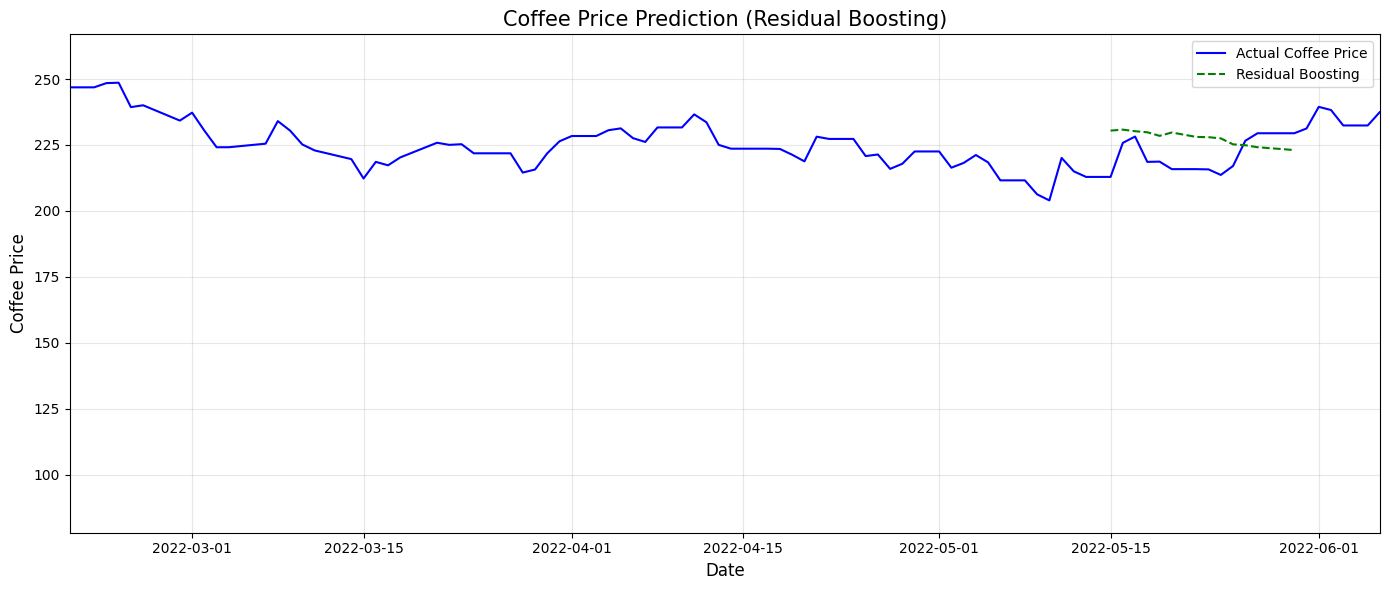


415개 테스트 시퀀스에 대한 예측 수행 중...
415개 시퀀스 예측 생성 완료
평균 13.6개의 예측이 각 날짜에 겹침


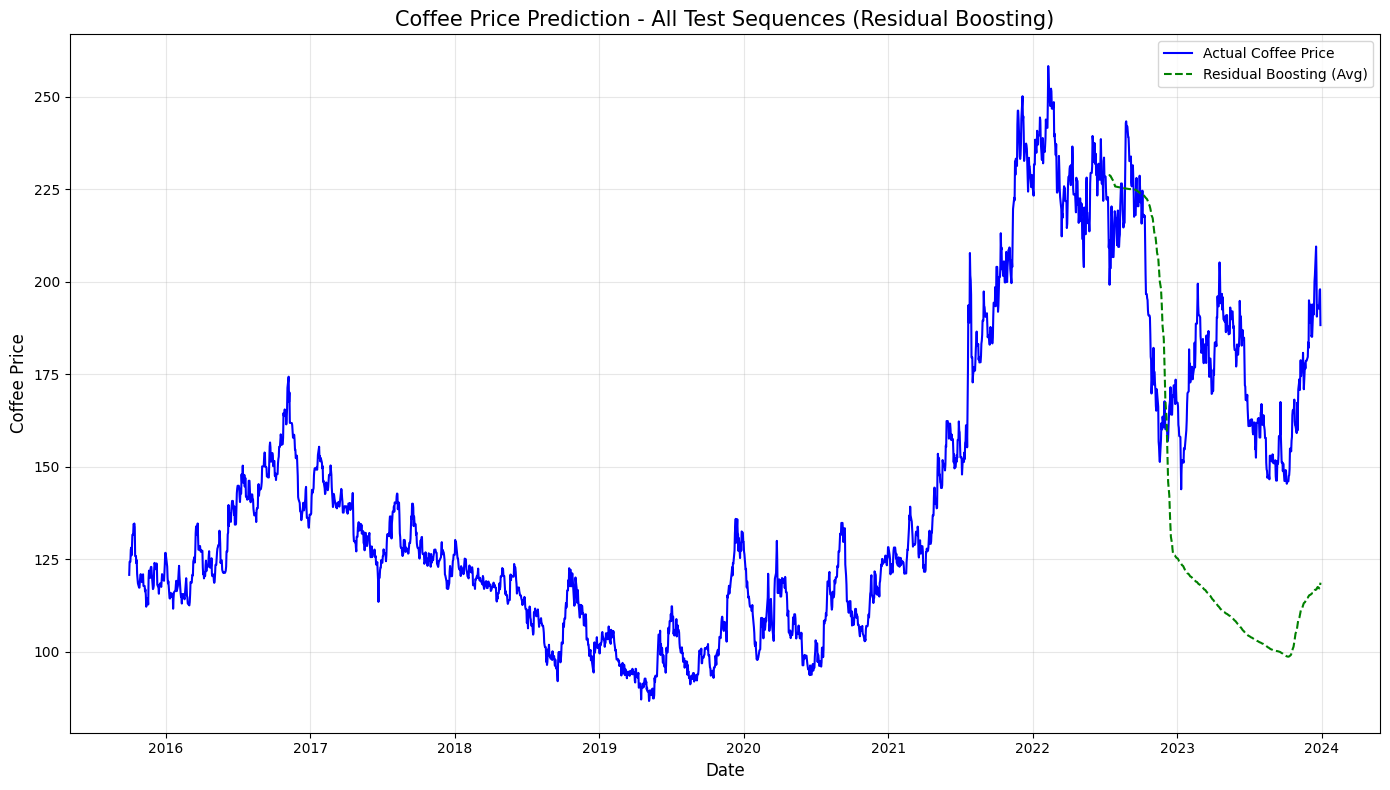

Prediction saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_residual_all_predictions_20250517.csv
Multiple predictions saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_residual_all_predictions_20250517.csv

성능 평가 (Residual Boosting):
MAE: 8.9494
RMSE: 10.0576
Direction Accuracy: 30.77%
Model saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/residual_model_20250517.pt
예측 결과 처음 5개: Date
2022-05-15    230.455506
2022-05-16    230.822000
2022-05-17    230.220490
2022-05-18    229.816641
2022-05-19    228.463148
dtype: float64


In [ ]:
macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'

# 3. 부스팅 모델 실행 (모든 부스팅 모델 비교)
# forecast_boosting, model_boosting = run_boosting_model_example(
#     macro_data_path=macro_data,
#     climate_data_path=climate_data,
#     output_path=output_path,
#     data_window=50,
#     future_target=14,
#     batch_size=10,
#     hidden_size=100,
#     n_estimators=3,
#     num_epochs=100
# )

# 또는 하나의 부스팅 모델만 실행
forecast, model = main_with_boosting(
    macro_data_path=macro_data,
    climate_data_path=climate_data,
    output_path=output_path,
    data_window=50,
    future_target=14,
    hidden_size=100,
    num_epochs=100,
    loss_fn='huber',
    use_boosting=True,
    n_estimators=3,
    boosting_type='residual'  # 'ensemble', 'residual', 'sequential' 중 선택
)


# 4. 결과 확인
print(f"예측 결과 처음 5개: {forecast.head()}")

In [ ]:
macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'

# 3. 부스팅 모델 실행 (모든 부스팅 모델 비교)
# forecast_boosting, model_boosting = run_boosting_model_example(
#     macro_data_path=macro_data,
#     climate_data_path=climate_data,
#     output_path=output_path,
#     data_window=50,
#     future_target=14,
#     batch_size=10,
#     hidden_size=100,
#     n_estimators=3,
#     num_epochs=100
# )

# 또는 하나의 부스팅 모델만 실행
forecast, model = main_with_boosting(
    macro_data_path=macro_data,
    climate_data_path=climate_data,
    output_path=output_path,
    data_window=50,
    future_target=14,
    hidden_size=100,
    num_epochs=100,
    loss_fn='huber',
    use_boosting=True,
    n_estimators=3,
    boosting_type='sequential'  # 'ensemble', 'residual', 'sequential' 중 선택
)


# 4. 결과 확인
print(f"예측 결과 처음 5개: {forecast.head()}")


=== Running with Sequential Boosting Model ===

Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)

학습 중: 순차적 부스팅 모델

===== Training Sequential Model 1/3 =====
Epoch [10/33], Loss: 0.0017
Epoch [20/33], Loss: 0.0013
Epoch [30/33], Loss: 0.0012
Residual stats - Mean: -0.0004, Std: 0.0386

===== Training Sequential Model 2/3 =====


RuntimeError: cudnn RNN backward can only be called in training mode


=== Running with Ensemble Boosting Model ===

Using device: cuda
Data loaded with shape: (2393, 66)
Training data: (1914, 66), Test data: (479, 66)

학습 중: 부스팅 앙상블 모델

===== Training Boosting Model 1/3 =====
Epoch [10/50], Loss: 0.0008
Epoch [20/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0005
Epoch [40/50], Loss: 0.0004
Epoch [50/50], Loss: 0.0004
After model 1, MSE: 0.0007, MAE: 0.0192

===== Training Boosting Model 2/3 =====
Epoch [10/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0003
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0002
After model 2, MSE: 0.0006, MAE: 0.0186

===== Training Boosting Model 3/3 =====
Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0002
Epoch [30/50], Loss: 0.0002
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0002
After model 3, MSE: 0.0006, MAE: 0.0187

Test Performance - MSE: 0.0374, MAE: 0.1628

미래 가격 예측 중...
Prediction saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_ensemble_prediction_20250517.

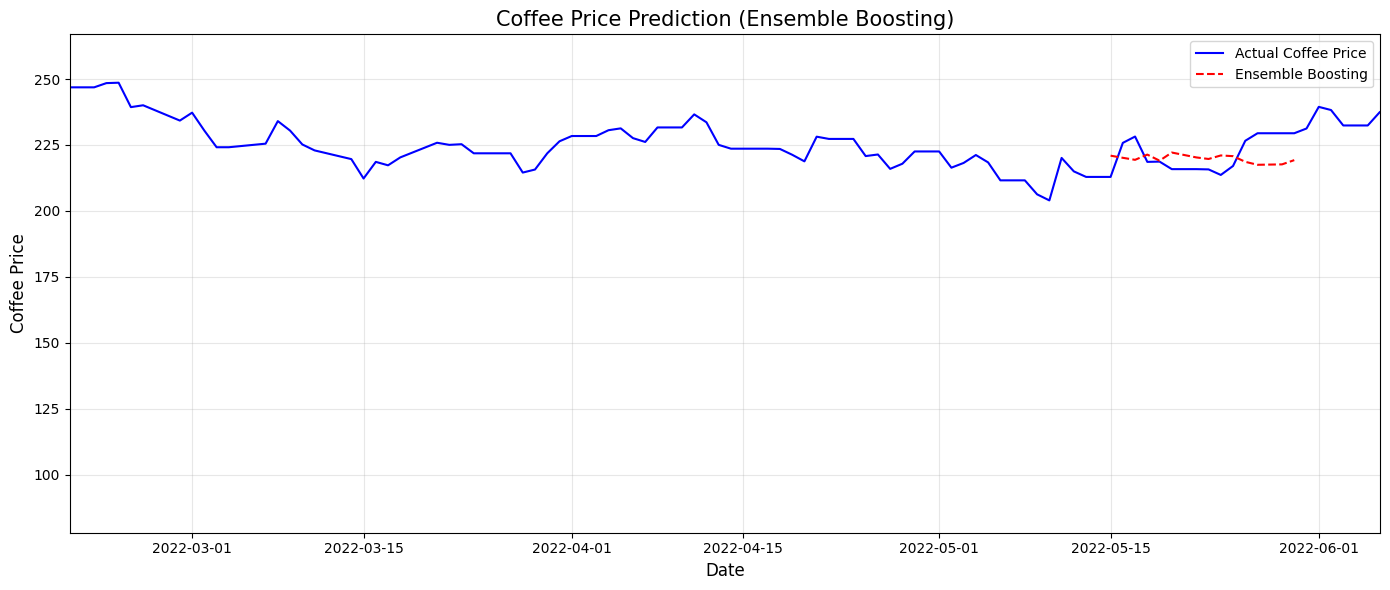


415개 테스트 시퀀스에 대한 예측 수행 중...
415개 시퀀스 예측 생성 완료
평균 13.6개의 예측이 각 날짜에 겹침


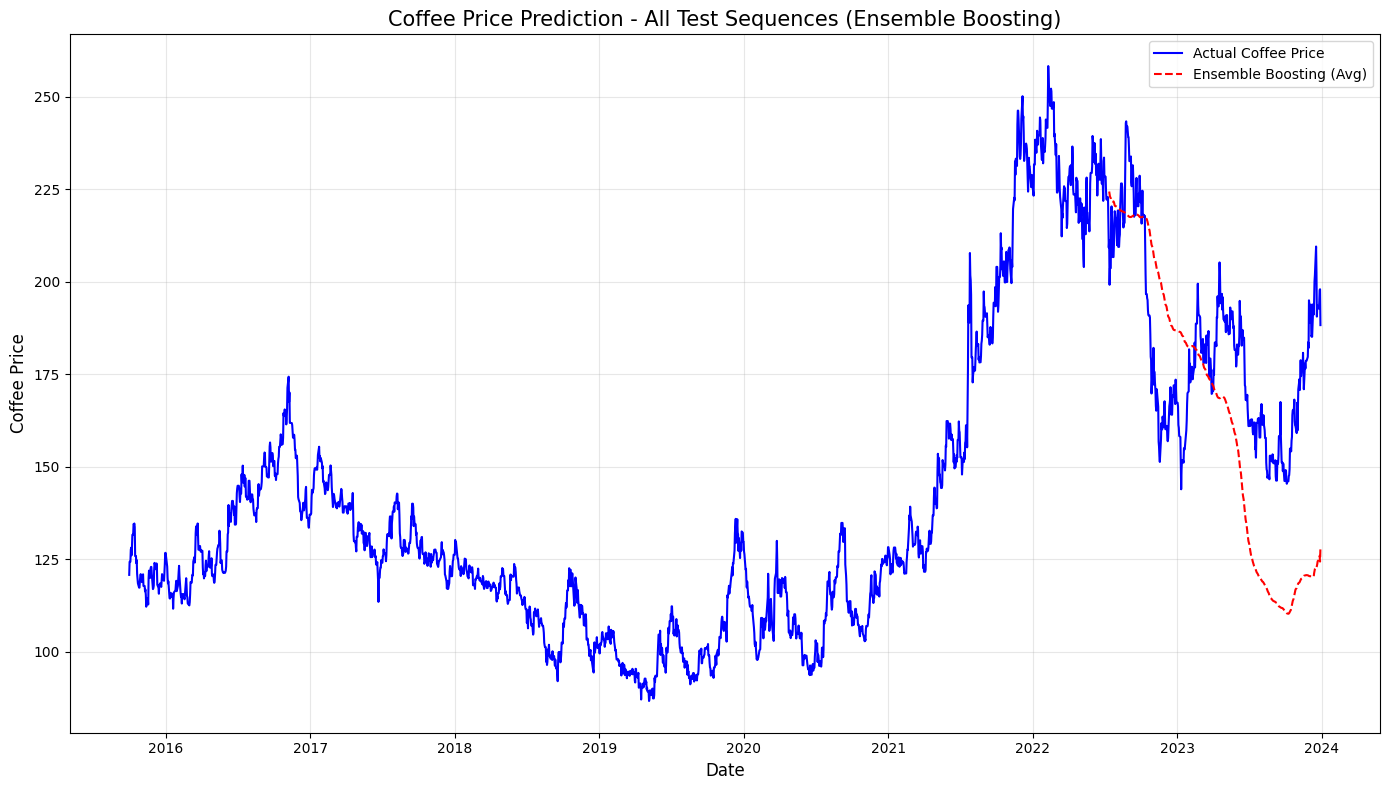

Prediction saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_ensemble_all_predictions_20250517.csv
Multiple predictions saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/coffee_ensemble_all_predictions_20250517.csv

성능 평가 (Ensemble Boosting):
MAE: 6.6680
RMSE: 7.4411
Direction Accuracy: 7.69%
Model saved to: /content/drive/MyDrive/Colab Notebooks/univ/capstone/ensemble_model_20250517.pt
예측 결과 처음 5개: Date
2022-05-15    220.951408
2022-05-16    220.144530
2022-05-17    219.376541
2022-05-18    221.360394
2022-05-19    219.058762
dtype: float64


In [ ]:
macro_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/거시경제및커피가격통합데이터.csv'
climate_data = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/기후데이터피쳐선택.csv'
output_path = '/content/drive/MyDrive/Colab Notebooks/univ/capstone/'

# 3. 부스팅 모델 실행 (모든 부스팅 모델 비교)
# forecast_boosting, model_boosting = run_boosting_model_example(
#     macro_data_path=macro_data,
#     climate_data_path=climate_data,
#     output_path=output_path,
#     data_window=50,
#     future_target=14,
#     batch_size=10,
#     hidden_size=100,
#     n_estimators=3,
#     num_epochs=100
# )

# 또는 하나의 부스팅 모델만 실행
forecast, model = main_with_boosting(
    macro_data_path=macro_data,
    climate_data_path=climate_data,
    output_path=output_path,
    data_window=50,
    future_target=14,
    hidden_size=100,
    num_epochs=100,
    loss_fn='huber',
    use_boosting=True,
    n_estimators=3,
    boosting_type='ensemble'  # 'ensemble', 'residual', 'sequential' 중 선택
)


# 4. 결과 확인
print(f"예측 결과 처음 5개: {forecast.head()}")